In [40]:
pip install geopy

In [2]:
#pip install --upgrade scikit-learn

In [102]:
# Libraries used:
import pandas as pd
import sqlite3
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN

Loading the files in the environment:

In [5]:
# Replace with the actual file paths of the downloaded dataset
transactions_file = "C:/Users/Raheb/Desktop/DS/sales_data.xlsx"
customers_file = "C:/Users/Raheb/Desktop/DS/customer_data.xlsx"
malls_file = "C:/Users/Raheb/Desktop/DS/shopping_mall_data.xlsx"

# Load the Excel files into DataFrames
df_transactions = pd.read_excel(transactions_file)
df_customers = pd.read_excel(customers_file)
df_malls = pd.read_excel(malls_file)

# Display the first few rows of each DataFrame to confirm successful loading
print("Transactions DataFrame head:")
print(df_transactions.head())

print("\nCustomers DataFrame head:")
print(df_customers.head())

print("\nMalls DataFrame head:")
print(df_malls.head())

Transactions DataFrame head:
  invoice_no customer_id  category  quantity invoice date    price  \
0    I138884     C241288  Clothing         5   05/08/2022  1500.40   
1    I317333     C111565     Shoes         3   12/12/2021  1800.51   
2    I127801     C266599  Clothing         1   09/11/2021   300.08   
3    I173702     C988172     Shoes         5   05/16/2021  3000.85   
4    I337046     C189076     Books         4   10/24/2021    60.60   

              shopping_mall  
0         South Coast Plaza  
1            Beverly Center  
2    Westfield Century City  
3  Stanford Shopping Center  
4         South Coast Plaza  

Customers DataFrame head:
  customer_id  gender   age payment_method
0     C241288  Female  28.0    Credit Card
1     C111565    Male  21.0     Debit Card
2     C266599    Male  20.0           Cash
3     C988172  Female  66.0    Credit Card
4     C189076  Female  53.0           Cash

Malls DataFrame head:
            shopping_mall  construction_year  area (sqm)     l

Changing column names for ease of use in the future and also making the code more efficent for sql usbability.

In [6]:
# Establishing SQLite connection
conn = sqlite3.connect(":memory:")  # Use in-memory database

# Loading the DataFrames into SQLite tables
df_transactions.to_sql("transactions", conn, index=False, if_exists="replace")
df_customers.to_sql("customers", conn, index=False, if_exists="replace")
df_malls.to_sql("malls", conn, index=False, if_exists="replace")

10

In [7]:
# Rename columns to replace spaces with underscores
df_transactions.rename(columns={"invoice date": "invoice_date"}, inplace=True)

# Reload DataFrame into SQLite
df_transactions.to_sql('transactions', conn, if_exists='replace', index=False)

99457

In [8]:
# Rename columns in the malls DataFrame
df_malls.rename(columns={"area (sqm)": "mall_area"}, inplace=True)

# Reload the DataFrame into SQLite
df_malls.to_sql('malls', conn, if_exists='replace', index=False)

10

In [9]:
# Checking for tables loaded in sql system to merge them into a single table.
query_tables = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query_tables, conn)
print("Existing tables in the database:")
print(tables)

Existing tables in the database:
           name
0     customers
1  transactions
2         malls


In [10]:
query = """
SELECT 
    t.invoice_no,
    t.customer_id,
    t.category,
    t.quantity,
    t.invoice_date,
    t.price,
    t.shopping_mall,
    c.gender,
    c.age,
    c.payment_method,
    m.construction_year,
    m.mall_area,
    m.location,
    m.store_count
FROM 
    transactions t
LEFT JOIN 
    customers c
ON 
    t.customer_id = c.customer_id
LEFT JOIN 
    malls m
ON 
    t.shopping_mall = m.shopping_mall
"""
merged_df = pd.read_sql_query(query, conn)

In [11]:
print(merged_df.head())

  invoice_no customer_id  category  quantity invoice_date    price  \
0    I138884     C241288  Clothing         5   05/08/2022  1500.40   
1    I317333     C111565     Shoes         3   12/12/2021  1800.51   
2    I127801     C266599  Clothing         1   09/11/2021   300.08   
3    I173702     C988172     Shoes         5   05/16/2021  3000.85   
4    I337046     C189076     Books         4   10/24/2021    60.60   

              shopping_mall  gender   age payment_method  construction_year  \
0         South Coast Plaza  Female  28.0    Credit Card             1967.0   
1            Beverly Center    Male  21.0     Debit Card             1982.0   
2    Westfield Century City    Male  20.0           Cash             1964.0   
3  Stanford Shopping Center  Female  66.0    Credit Card             1956.0   
4         South Coast Plaza  Female  53.0           Cash             1967.0   

   mall_area     location  store_count  
0   250000.0   Costa Mesa        270.0  
1   111000.0  Los Ange

Data Preprocessing

In [12]:
# Check for missing values:
merged_df.isnull().sum()

invoice_no              0
customer_id             0
category                0
quantity                0
invoice_date            0
price                   0
shopping_mall           0
gender                  0
age                   119
payment_method          0
construction_year    4991
mall_area            4991
location             4991
store_count          4991
dtype: int64

In [13]:
total_rows = merged_df.shape[0]
print(f"Total rows in the table: {total_rows}")

Total rows in the table: 99457


In [14]:
# Impute missing values for 'invoice_date' using the mode (most frequent value)
merged_df['invoice_date'].fillna(merged_df['invoice_date'].mode()[0], inplace=True)

# Drop rows with missing values in specific columns related to mall information
merged_df_cleaned = merged_df.dropna(subset=['construction_year', 'mall_area', 'location', 'store_count'])

# Verify the changes
print("Missing values after imputation and dropping rows:", merged_df_cleaned.isnull().sum())
print("Total rows after cleaning:", merged_df_cleaned.shape[0])

Missing values after imputation and dropping rows: invoice_no             0
customer_id            0
category               0
quantity               0
invoice_date           0
price                  0
shopping_mall          0
gender                 0
age                  117
payment_method         0
construction_year      0
mall_area              0
location               0
store_count            0
dtype: int64
Total rows after cleaning: 94466


In [15]:
# Impute missing values in the 'age' column using the mode (most frequent value)
merged_df_cleaned['age'].fillna(merged_df_cleaned['age'].mode()[0], inplace=True)
# Verify the changes
print("Missing values after imputing 'age':", merged_df_cleaned.isnull().sum())
print("Total rows after cleaning:", merged_df_cleaned.shape[0])

Missing values after imputing 'age': invoice_no           0
customer_id          0
category             0
quantity             0
invoice_date         0
price                0
shopping_mall        0
gender               0
age                  0
payment_method       0
construction_year    0
mall_area            0
location             0
store_count          0
dtype: int64
Total rows after cleaning: 94466


C:\Users\Raheb\AppData\Local\Temp\ipykernel_88732\365892424.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_cleaned['age'].fillna(merged_df_cleaned['age'].mode()[0], inplace=True)


In [16]:
# Convert 'invoice_date' to datetime
merged_df_cleaned.loc[:, 'invoice_date'] = pd.to_datetime(merged_df_cleaned['invoice_date'], format='%m/%d/%Y')

# Convert 'quantity' to integer
merged_df_cleaned.loc[:, 'quantity'] = merged_df_cleaned['quantity'].astype(int)

# Convert 'price' to float
merged_df_cleaned.loc[:, 'price'] = merged_df_cleaned['price'].astype(float)

In [17]:
merged_df_cleaned.head()

,invoice_no,customer_id,category,quantity,invoice_date,price,shopping_mall,gender,age,payment_method,construction_year,mall_area,location,store_count
0,I138884,C241288,Clothing,5,2022-05-08 00:00:00,1500.40,South Coast Plaza,Female,28.0,Credit Card,1967.0,250000.0,Costa Mesa,270.0
1,I317333,C111565,Shoes,3,2021-12-12 00:00:00,1800.51,Beverly Center,Male,21.0,Debit Card,1982.0,111000.0,Los Angeles,160.0
2,I127801,C266599,Clothing,1,2021-09-11 00:00:00,300.08,Westfield Century City,Male,20.0,Cash,1964.0,133000.0,Los Angeles,200.0
3,I173702,C988172,Shoes,5,2021-05-16 00:00:00,3000.85,Stanford Shopping Center,Female,66.0,Credit Card,1956.0,120000.0,Palo Alto,140.0
4,I337046,C189076,Books,4,2021-10-24 00:00:00,60.60,South Coast Plaza,Female,53.0,Cash,1967.0,250000.0,Costa Mesa,270.0


In [18]:
# Display distinct values count for each column
distinct_counts = merged_df_cleaned.nunique()
print(distinct_counts)

invoice_no           94466
customer_id          94466
category                 8
quantity                 5
invoice_date           797
price                   40
shopping_mall            9
gender                   2
age                     52
payment_method           3
construction_year        9
mall_area                9
location                 7
store_count              8
dtype: int64


In [19]:
# To find the date range in the dataset for addition of weather data.
min_date = merged_df_cleaned['invoice_date'].min()
max_date = merged_df_cleaned['invoice_date'].max()

print(f"Date Range: {min_date} to {max_date}")

Date Range: 2021-01-01 00:00:00 to 2023-12-02 00:00:00


In [20]:
# Checking for weather data based on these specific locations.
unique_locations = merged_df_cleaned['location'].unique()
print(unique_locations)

['Costa Mesa' 'Los Angeles' 'Palo Alto' 'Santa Clara' 'Torrance'
 'Glendale' 'San Diego']


In [21]:
# Convert invoice_date to datetime
merged_df_cleaned['invoice_date'] = pd.to_datetime(merged_df_cleaned['invoice_date'], errors='coerce')

# Get distinct invoice dates for 2021
distinct_invoice_dates_2021 = merged_df_cleaned[merged_df_cleaned['invoice_date'].dt.year == 2021]['invoice_date'].drop_duplicates().sort_values()

# Display distinct values
print(distinct_invoice_dates_2021)

4296   2021-01-01
3688   2021-01-02
567    2021-01-03
247    2021-01-04
845    2021-01-05
          ...    
627    2021-12-27
1536   2021-12-28
259    2021-12-29
1093   2021-12-30
1248   2021-12-31
Name: invoice_date, Length: 365, dtype: datetime64[ns]


C:\Users\Raheb\AppData\Local\Temp\ipykernel_88732\70255218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_cleaned['invoice_date'] = pd.to_datetime(merged_df_cleaned['invoice_date'], errors='coerce')


In [22]:
# Adding additonal datasets for California weather and US Holidays.
# Reading the holiday dataset
holiday_df = pd.read_csv(r"C:\Users\Raheb\Desktop\DS\US Holiday Dates (2004-2021).csv")

# Reading the weather datasets
weather_df_1 = pd.read_csv(r"C:\Users\Raheb\Desktop\DS\california 2021-01-01 to 2023-01-01.csv")
weather_df_2 = pd.read_csv(r"C:\Users\Raheb\Desktop\DS\california 2023-01-02 to 2023-12-02.csv")

# Display first few rows to confirm successful loading
print("Holiday Data:")
print(holiday_df.head())

print("\nWeather Data 1:")
print(weather_df_1.head())

print("\nWeather Data 2:")
print(weather_df_2.head())

Holiday Data:
         Date      Holiday    WeekDay  Month  Day  Year
0  2004-07-04  4th of July     Sunday      7    4  2004
1  2005-07-04  4th of July     Monday      7    4  2005
2  2006-07-04  4th of July    Tuesday      7    4  2006
3  2007-07-04  4th of July  Wednesday      7    4  2007
4  2008-07-04  4th of July     Friday      7    4  2008

Weather Data 1:
         name    datetime  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
0  california  2021-01-01     55.0     37.0  45.8          55.0          35.5   
1  california  2021-01-02     51.4     46.9  48.9          51.4          45.6   
2  california  2021-01-03     55.7     47.3  49.8          55.7          45.7   
3  california  2021-01-04     58.0     46.2  52.3          58.0          43.5   
4  california  2021-01-05     57.8     37.1  45.1          57.8          34.0   

   feelslike   dew  humidity  ...  solarenergy  uvindex  severerisk  \
0       44.3  40.0      80.6  ...          9.2        5         NaN   
1   

In [23]:
# Combining the two weather datasets
combined_weather_df = pd.concat([weather_df_1, weather_df_2], ignore_index=True)

# Display first few rows to confirm the merge
print("Combined Weather Data:")
print(combined_weather_df.head())

Combined Weather Data:
         name    datetime  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
0  california  2021-01-01     55.0     37.0  45.8          55.0          35.5   
1  california  2021-01-02     51.4     46.9  48.9          51.4          45.6   
2  california  2021-01-03     55.7     47.3  49.8          55.7          45.7   
3  california  2021-01-04     58.0     46.2  52.3          58.0          43.5   
4  california  2021-01-05     57.8     37.1  45.1          57.8          34.0   

   feelslike   dew  humidity  ...  solarenergy  uvindex  severerisk  \
0       44.3  40.0      80.6  ...          9.2        5         NaN   
1       48.4  45.4      88.0  ...          3.4        2         NaN   
2       49.4  47.2      91.0  ...          8.9        6         NaN   
3       51.8  47.7      84.6  ...          1.3        1         NaN   
4       43.9  41.1      86.3  ...         11.2        6         NaN   

               sunrise               sunset  moonphase  \
0  20

In [24]:
# Checking Data types of all date related columns for integration.
# Using .loc[] to avoid the SettingWithCopyWarning
merged_df_cleaned['invoice_date'] = pd.to_datetime(merged_df_cleaned['invoice_date'], errors='coerce')
holiday_df['Date'] = pd.to_datetime(holiday_df['Date'], errors='coerce')
combined_weather_df['datetime'] = pd.to_datetime(combined_weather_df['datetime'], errors='coerce')

C:\Users\Raheb\AppData\Local\Temp\ipykernel_88732\2715799296.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_cleaned['invoice_date'] = pd.to_datetime(merged_df_cleaned['invoice_date'], errors='coerce')


In [25]:
print(merged_df_cleaned['invoice_date'].dtype)
print(holiday_df['Date'].dtype)
print(combined_weather_df['datetime'].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]


In [26]:
print(merged_df_cleaned['invoice_date'].head())
print(holiday_df['Date'].head())
print(combined_weather_df['datetime'].head())

0   2022-05-08
1   2021-12-12
2   2021-09-11
3   2021-05-16
4   2021-10-24
Name: invoice_date, dtype: datetime64[ns]
0   2004-07-04
1   2005-07-04
2   2006-07-04
3   2007-07-04
4   2008-07-04
Name: Date, dtype: datetime64[ns]
0   2021-01-01
1   2021-01-02
2   2021-01-03
3   2021-01-04
4   2021-01-05
Name: datetime, dtype: datetime64[ns]


In [27]:
# Checking the date range in all datasets
print("Merged Sales Data (merged_df_cleaned):")
print(f"Min Date: {merged_df_cleaned['invoice_date'].min()}, Max Date: {merged_df_cleaned['invoice_date'].max()}")

print("\nHoliday Data (holiday_df):")
print(f"Min Date: {holiday_df['Date'].min()}, Max Date: {holiday_df['Date'].max()}")

print("\nWeather Data (combined_weather_df):")
print(f"Min Date: {combined_weather_df['datetime'].min()}, Max Date: {combined_weather_df['datetime'].max()}")

Merged Sales Data (merged_df_cleaned):
Min Date: 2021-01-01 00:00:00, Max Date: 2023-12-02 00:00:00

Holiday Data (holiday_df):
Min Date: 2004-01-01 00:00:00, Max Date: 2021-12-31 00:00:00

Weather Data (combined_weather_df):
Min Date: 2021-01-01 00:00:00, Max Date: 2023-12-02 00:00:00


In [28]:
print(holiday_df['Holiday'].unique())

['4th of July' 'Christmas Day' 'Christmas Eve' 'Columbus Day'
 'Eastern Easter' 'Juneteenth' 'Labor Day' 'Labor Day Weekend'
 'Martin Luther King, Jr. Day' 'Memorial Day' "New Year's Day"
 'New Year’s Eve' 'Thanksgiving Day' 'Thanksgiving Eve' 'Valentine’s Day'
 'Veterans Day' "Washington's Birthday" 'Western Easter']


In [29]:
# Federal Holidays for 2021, 2022, 2023
federal_holidays_data = {
    'Date': [
        # 2023 Federal Holidays
        '2023-01-01', '2023-01-16', '2023-02-20', '2023-05-29', '2023-06-19', '2023-07-04', '2023-09-04', '2023-10-09', '2023-11-10', '2023-11-23', '2023-12-25',
        # 2022 Federal Holidays
        '2022-01-01', '2022-01-17', '2022-02-21', '2022-05-30', '2022-06-20', '2022-07-04', '2022-09-05', '2022-10-10', '2022-11-11', '2022-11-24', '2022-12-26',
        # 2021 Federal Holidays
        '2021-01-01', '2021-01-18', '2021-02-15', '2021-05-31', '2021-06-18', '2021-07-05', '2021-09-06', '2021-10-11', '2021-11-11', '2021-11-25', '2021-12-24'
    ],
    'Holiday': [
        # 2023 Federal Holidays
        'New Year\'s Day', 'Martin Luther King Jr. Day', 'Washington\'s Birthday', 'Memorial Day', 'Juneteenth National Independence Day', 'Independence Day', 'Labor Day', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day', 'Christmas Day',
        # 2022 Federal Holidays
        'New Year\'s Day', 'Martin Luther King Jr. Day', 'Washington\'s Birthday', 'Memorial Day', 'Juneteenth National Independence Day', 'Independence Day', 'Labor Day', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day', 'Christmas Day',
        # 2021 Federal Holidays
        'New Year\'s Day', 'Martin Luther King Jr. Day', 'Washington\'s Birthday', 'Memorial Day', 'Juneteenth National Independence Day', 'Independence Day', 'Labor Day', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day', 'Christmas Day'
    ]
}

# Creating the DataFrame for Federal Holidays
federal_holidays_df = pd.DataFrame(federal_holidays_data)

# Converting 'Date' column to datetime
federal_holidays_df['Date'] = pd.to_datetime(federal_holidays_df['Date'])

# Creating the sales events and other holidays DataFrame (from previous step)
sales_and_other_holidays_data = {
    'Date': [
        '2023-11-24', '2023-11-27', '2023-02-14', '2023-05-14', '2023-06-18', '2023-04-09', '2023-09-04', '2023-08-01', '2023-07-10',  # 2023 Holidays
        '2022-11-25', '2022-11-28', '2022-02-14', '2022-05-08', '2022-06-19', '2022-04-17', '2022-09-05', '2022-08-01', '2022-07-12',  # 2022 Holidays
        '2021-11-26', '2021-11-29', '2021-02-14', '2021-05-09', '2021-06-20', '2021-04-04', '2021-09-06', '2021-08-01', '2021-07-12'   # 2021 Holidays
    ],
    'Special_Events': [
        'Black Friday', 'Cyber Monday', 'Valentine\'s Day', 'Mother\'s Day', 'Father\'s Day', 'Easter', 'Labor Day', 'Back to School', 'Prime Day',  # 2023 Holidays
        'Black Friday', 'Cyber Monday', 'Valentine\'s Day', 'Mother\'s Day', 'Father\'s Day', 'Easter', 'Labor Day', 'Back to School', 'Prime Day',  # 2022 Holidays
        'Black Friday', 'Cyber Monday', 'Valentine\'s Day', 'Mother\'s Day', 'Father\'s Day', 'Easter', 'Labor Day', 'Back to School', 'Prime Day'   # 2021 Holidays
    ]
}

# Creating the DataFrame for Sales and Other Holidays
sales_and_other_holidays_df = pd.DataFrame(sales_and_other_holidays_data)

# Converting 'Date' column to datetime
sales_and_other_holidays_df['Date'] = pd.to_datetime(sales_and_other_holidays_df['Date'])

# Combine both Federal Holidays and Sales Events DataFrames
combined_holiday_df = pd.concat([federal_holidays_df, sales_and_other_holidays_df], ignore_index=True)

# Sorting by Date for better organization
combined_holiday_df.sort_values(by='Date', ascending=True, inplace=True)

# Display the final combined dataset
print(combined_holiday_df)

         Date                               Holiday   Special_Events
22 2021-01-01                        New Year's Day              NaN
23 2021-01-18            Martin Luther King Jr. Day              NaN
53 2021-02-14                                   NaN  Valentine's Day
24 2021-02-15                 Washington's Birthday              NaN
56 2021-04-04                                   NaN           Easter
54 2021-05-09                                   NaN     Mother's Day
25 2021-05-31                          Memorial Day              NaN
26 2021-06-18  Juneteenth National Independence Day              NaN
55 2021-06-20                                   NaN     Father's Day
27 2021-07-05                      Independence Day              NaN
59 2021-07-12                                   NaN        Prime Day
58 2021-08-01                                   NaN   Back to School
57 2021-09-06                                   NaN        Labor Day
28 2021-09-06                     

In [30]:
print(combined_holiday_df.dtypes)

Date              datetime64[ns]
Holiday                   object
Special_Events            object
dtype: object


In [31]:
# Check if 'Date' is in both dataframes
print(merged_df_cleaned.columns)
print(combined_holiday_df.columns)

Index(['invoice_no', 'customer_id', 'category', 'quantity', 'invoice_date',
       'price', 'shopping_mall', 'gender', 'age', 'payment_method',
       'construction_year', 'mall_area', 'location', 'store_count'],
      dtype='object')
Index(['Date', 'Holiday', 'Special_Events'], dtype='object')


In [32]:
# Joining the new created tables with the Dataframe:
# Rename 'invoice_date' to 'Date' in merged_df_cleaned
merged_df_cleaned = merged_df_cleaned.rename(columns={'invoice_date': 'Date'})

# Ensure both 'Date' columns are in datetime format
merged_df_cleaned['Date'] = pd.to_datetime(merged_df_cleaned['Date'])
combined_holiday_df['Date'] = pd.to_datetime(combined_holiday_df['Date'])

# Now, merge the dataframes on 'Date'
merged_with_special_events = pd.merge(
    merged_df_cleaned, 
    combined_holiday_df[['Date', 'Holiday', 'Special_Events']], 
    how='left', 
    on='Date'
)

# Create a new column 'Has_Special_Event' where True (1) if a holiday or special event is present, else False (0)
merged_with_special_events['Has_Special_Event'] = merged_with_special_events['Holiday'].notnull() | merged_with_special_events['Special_Events'].notnull()

# Check the result
print(merged_with_special_events.head())

  invoice_no customer_id  category  quantity       Date    price  \
0    I138884     C241288  Clothing         5 2022-05-08  1500.40   
1    I317333     C111565     Shoes         3 2021-12-12  1800.51   
2    I127801     C266599  Clothing         1 2021-09-11   300.08   
3    I173702     C988172     Shoes         5 2021-05-16  3000.85   
4    I337046     C189076     Books         4 2021-10-24    60.60   

              shopping_mall  gender   age payment_method  construction_year  \
0         South Coast Plaza  Female  28.0    Credit Card             1967.0   
1            Beverly Center    Male  21.0     Debit Card             1982.0   
2    Westfield Century City    Male  20.0           Cash             1964.0   
3  Stanford Shopping Center  Female  66.0    Credit Card             1956.0   
4         South Coast Plaza  Female  53.0           Cash             1967.0   

   mall_area     location  store_count Holiday Special_Events  \
0   250000.0   Costa Mesa        270.0     NaN   Mo

In [34]:
# Joining weather dataset with the rest of the data.
# Rename 'datetime' to 'Date' for consistency
combined_weather_df = combined_weather_df.rename(columns={'datetime': 'Date'})

# Ensure the 'Date' column is in datetime format
merged_with_special_events['Date'] = pd.to_datetime(merged_with_special_events['Date'])
combined_weather_df['Date'] = pd.to_datetime(combined_weather_df['Date'])

# Merge the weather data with the existing dataframe on 'Date'
final_merged_df = pd.merge(
    merged_with_special_events, 
    combined_weather_df[['Date', 'tempmax', 'tempmin', 'temp', 'humidity', 'icon']], 
    how='left', 
    on='Date'
)

# Check the result
print(final_merged_df.head())

  invoice_no customer_id  category  quantity       Date    price  \
0    I138884     C241288  Clothing         5 2022-05-08  1500.40   
1    I317333     C111565     Shoes         3 2021-12-12  1800.51   
2    I127801     C266599  Clothing         1 2021-09-11   300.08   
3    I173702     C988172     Shoes         5 2021-05-16  3000.85   
4    I337046     C189076     Books         4 2021-10-24    60.60   

              shopping_mall  gender   age payment_method  ...     location  \
0         South Coast Plaza  Female  28.0    Credit Card  ...   Costa Mesa   
1            Beverly Center    Male  21.0     Debit Card  ...  Los Angeles   
2    Westfield Century City    Male  20.0           Cash  ...  Los Angeles   
3  Stanford Shopping Center  Female  66.0    Credit Card  ...    Palo Alto   
4         South Coast Plaza  Female  53.0           Cash  ...   Costa Mesa   

   store_count Holiday  Special_Events Has_Special_Event tempmax  tempmin  \
0        270.0     NaN    Mother's Day       

In [35]:
print(final_merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94693 entries, 0 to 94692
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   invoice_no         94693 non-null  object        
 1   customer_id        94693 non-null  object        
 2   category           94693 non-null  object        
 3   quantity           94693 non-null  int64         
 4   Date               94693 non-null  datetime64[ns]
 5   price              94693 non-null  float64       
 6   shopping_mall      94693 non-null  object        
 7   gender             94693 non-null  object        
 8   age                94693 non-null  float64       
 9   payment_method     94693 non-null  object        
 10  construction_year  94693 non-null  float64       
 11  mall_area          94693 non-null  float64       
 12  location           94693 non-null  object        
 13  store_count        94693 non-null  float64       
 14  Holida

In [36]:
print(final_merged_df['Holiday'].unique())
print(final_merged_df['Has_Special_Event'].nunique())

[nan 'Columbus Day' 'Juneteenth National Independence Day' 'Labor Day'
 'Independence Day' 'Veterans Day' "Washington's Birthday"
 'Martin Luther King Jr. Day' 'Memorial Day' "New Year's Day"
 'Thanksgiving Day' 'Christmas Day']
2


In [37]:
# Count the number of True and False values in the 'Has_Special_Event' column
true_count = final_merged_df['Has_Special_Event'].sum()
false_count = len(final_merged_df) - true_count

# Print the counts
print(f"True values: {true_count}")
print(f"False values: {false_count}")

True values: 5216
False values: 89477


In [38]:
print(final_merged_df['shopping_mall'].unique())
print(final_merged_df['location'].unique())

['South Coast Plaza' 'Beverly Center' 'Westfield Century City'
 'Stanford Shopping Center' 'Westfield Valley Fair'
 'Del Amo Fashion Center' 'The Grove' 'Glendale Galleria' 'Fashion Valley']
['Costa Mesa' 'Los Angeles' 'Palo Alto' 'Santa Clara' 'Torrance'
 'Glendale' 'San Diego']


In [41]:
# Adding location coordinates data.
# Cross Verifying the data.
# Create a geolocator instance
geolocator = Nominatim(user_agent="coordinate_verifier")

# List of coordinates for verification
coordinates = [
    (33 + 41/60 + 26.28/3600, -117 - 53/60 - 21.24/3600)
    (34.074921, -118.377518),  # Beverly Center
    (34.058601, -118.418999),  # Westfield Century City
    (37.441925, -122.171928),  # Stanford Shopping Center
    (37.325565, -121.945000),  # Westfield Valley Fair
    (33.690633, -117.889233),  # South Coast Plaza
    (33.840550, -118.337000),  # Del Amo Fashion Center
    (34.07198, -118.358009),   # The Grove
    (34.145894, -118.258283),  # Glendale Galleria
    (32.767222, -117.168056)   # Fashion Valley
]

# Verify coordinates
for lat, lon in coordinates:
    location = geolocator.reverse((lat, lon), language="en")
    print(f"Coordinates ({lat}, {lon}) correspond to: {location}")

<>:8: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:8: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
C:\Users\Raheb\AppData\Local\Temp\ipykernel_88732\3702257961.py:8: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  (33 + 41/60 + 26.28/3600, -117 - 53/60 - 21.24/3600)


TypeError: 'tuple' object is not callable

In [42]:
print(final_merged_df.columns)

Index(['invoice_no', 'customer_id', 'category', 'quantity', 'Date', 'price',
       'shopping_mall', 'gender', 'age', 'payment_method', 'construction_year',
       'mall_area', 'location', 'store_count', 'Holiday', 'Special_Events',
       'Has_Special_Event', 'tempmax', 'tempmin', 'temp', 'humidity', 'icon'],
      dtype='object')


In [43]:
# Adding coordinates for mapping purposes.
mall_coordinates = {
    "Beverly Center": (34.074921, -118.377518),
    "Westfield Century City": (34.058601, -118.418999),
    "Stanford Shopping Center": (37.441925, -122.171928),
    "Westfield Valley Fair": (37.325565, -121.945000),
    "South Coast Plaza": (33.690633, -117.889233),
    "Del Amo Fashion Center": (33.840550, -118.337000),
    "The Grove": (34.07198, -118.358009),
    "Glendale Galleria": (34.145894, -118.258283),
    "Fashion Valley": (32.767222, -117.168056)
}

# Check if the "Mall Name" column exists
if "shopping_mall" in final_merged_df.columns:
    # Create new columns for latitude and longitude
    final_merged_df["Latitude"] = final_merged_df["shopping_mall"].map(lambda x: mall_coordinates.get(x, (None, None))[0])
    final_merged_df["Longitude"] = final_merged_df["shopping_mall"].map(lambda x: mall_coordinates.get(x, (None, None))[1])
else:
    print("Error: 'Mall Name' column not found in final_merged_df")


print(final_merged_df[["shopping_mall", "Latitude", "Longitude"]])

                  shopping_mall   Latitude   Longitude
0             South Coast Plaza  33.690633 -117.889233
1                Beverly Center  34.074921 -118.377518
2        Westfield Century City  34.058601 -118.418999
3      Stanford Shopping Center  37.441925 -122.171928
4             South Coast Plaza  33.690633 -117.889233
...                         ...        ...         ...
94688         South Coast Plaza  33.690633 -117.889233
94689            Beverly Center  34.074921 -118.377518
94690    Westfield Century City  34.058601 -118.418999
94691     Westfield Valley Fair  37.325565 -121.945000
94692    Del Amo Fashion Center  33.840550 -118.337000

[94693 rows x 3 columns]


In [44]:
print(final_merged_df.columns)

Index(['invoice_no', 'customer_id', 'category', 'quantity', 'Date', 'price',
       'shopping_mall', 'gender', 'age', 'payment_method', 'construction_year',
       'mall_area', 'location', 'store_count', 'Holiday', 'Special_Events',
       'Has_Special_Event', 'tempmax', 'tempmin', 'temp', 'humidity', 'icon',
       'Latitude', 'Longitude'],
      dtype='object')


In [45]:
# Check total missing values per column
print(final_merged_df.isna().sum())

# Check percentage of missing values
missing_percentage = (final_merged_df.isna().sum() / len(final_merged_df)) * 100
print(missing_percentage)

invoice_no               0
customer_id              0
category                 0
quantity                 0
Date                     0
price                    0
shopping_mall            0
gender                   0
age                      0
payment_method           0
construction_year        0
mall_area                0
location                 0
store_count              0
Holiday              91745
Special_Events       92425
Has_Special_Event        0
tempmax                  0
tempmin                  0
temp                     0
humidity                 0
icon                     0
Latitude                 0
Longitude                0
dtype: int64
invoice_no            0.000000
customer_id           0.000000
category              0.000000
quantity              0.000000
Date                  0.000000
price                 0.000000
shopping_mall         0.000000
gender                0.000000
age                   0.000000
payment_method        0.000000
construction_year     0.00000

In [46]:
# Handling missing values for columns 'Holidays' and 'Special Events'
final_merged_df['Holiday'].fillna('No Holiday', inplace=True)

final_merged_df['Special_Events'].fillna('No Event', inplace=True)

In [47]:
# Check total missing values per column
print(final_merged_df.isna().sum())

invoice_no           0
customer_id          0
category             0
quantity             0
Date                 0
price                0
shopping_mall        0
gender               0
age                  0
payment_method       0
construction_year    0
mall_area            0
location             0
store_count          0
Holiday              0
Special_Events       0
Has_Special_Event    0
tempmax              0
tempmin              0
temp                 0
humidity             0
icon                 0
Latitude             0
Longitude            0
dtype: int64


Exploratory Data Analysis

In [48]:
print(final_merged_df.dtypes)

invoice_no                   object
customer_id                  object
category                     object
quantity                      int64
Date                 datetime64[ns]
price                       float64
shopping_mall                object
gender                       object
age                         float64
payment_method               object
construction_year           float64
mall_area                   float64
location                     object
store_count                 float64
Holiday                      object
Special_Events               object
Has_Special_Event              bool
tempmax                     float64
tempmin                     float64
temp                        float64
humidity                    float64
icon                         object
Latitude                    float64
Longitude                   float64
dtype: object


In [49]:
categorical_cols = ['category', 'shopping_mall', 'gender', 'payment_method', 'Holiday', 'Special_Events', 'icon', 'location']
final_merged_df[categorical_cols] = final_merged_df[categorical_cols].astype('category')

In [50]:
# Summary Statistics 
print(final_merged_df.describe())

           quantity                           Date         price  \
count  94693.000000                          94693  94693.000000   
mean       3.003485  2022-02-09 13:48:45.187712256    689.277828   
min        1.000000            2021-01-01 00:00:00      5.230000   
25%        2.000000            2021-07-20 00:00:00     45.450000   
50%        3.000000            2022-02-05 00:00:00    203.300000   
75%        4.000000            2022-08-23 00:00:00   1200.320000   
max        5.000000            2023-12-02 00:00:00   5250.000000   
std        1.412603                            NaN    940.444824   

                age  construction_year      mall_area   store_count  \
count  94693.000000       94693.000000   94693.000000  94693.000000   
mean      43.412977        1969.617342  183116.471122    208.816702   
min       18.000000        1956.000000   56000.000000    140.000000   
25%       30.000000        1961.000000  133000.000000    180.000000   
50%       43.000000        1967.

In [51]:
print(final_merged_df['category'].value_counts())
print(final_merged_df['shopping_mall'].value_counts())

category
Clothing           32837
Cosmetics          14405
Food & Beverage    14034
Toys                9590
Shoes               9566
Souvenir            4769
Technology          4754
Books               4738
Name: count, dtype: int64
shopping_mall
Del Amo Fashion Center      20000
South Coast Plaza           19864
Westfield Century City      15042
Stanford Shopping Center    10181
Westfield Valley Fair        9809
Fashion Valley               5087
Beverly Center               4954
Glendale Galleria            4925
The Grove                    4831
Name: count, dtype: int64


In [52]:
print(final_merged_df['quantity'].tail())

94688    5
94689    2
94690    2
94691    4
94692    3
Name: quantity, dtype: int64


Feature Engineering

In [53]:
# Calculating total price as data library says price per unit.
final_merged_df['total_spend'] = final_merged_df['quantity'] * final_merged_df['price']

In [54]:
final_merged_df['Date'] = pd.to_datetime(final_merged_df['Date'])  # Ensuring Date is in datetime format
final_merged_df['is_weekend'] = final_merged_df['Date'].dt.weekday >= 5  # Saturday (5) or Sunday (6)
final_merged_df['is_weekend'] = final_merged_df['is_weekend'].astype(int)

In [55]:
final_merged_df['month'] = final_merged_df['Date'].dt.month  # Extracting month
final_merged_df['weekday'] = final_merged_df['Date'].dt.weekday  # Extracting weekday (0=Monday, 6=Sunday)
final_merged_df['quarter'] = final_merged_df['Date'].dt.quarter  # Extracting quarter (1-4)

In [56]:
# Check the first few rows to verify if the total_sales column is correct
final_merged_df[['price', 'quantity', 'total_spend', 'category']].head()

,price,quantity,total_spend,category
0,1500.40,5,7502.00,Clothing
1,1800.51,3,5401.53,Shoes
2,300.08,1,300.08,Clothing
3,3000.85,5,15004.25,Shoes
4,60.60,4,242.40,Books


In [57]:
# Checking the first few rows to verify the new columns
final_merged_df[['Date', 'is_weekend', 'month', 'weekday', 'quarter']].head()

,Date,is_weekend,month,weekday,quarter
0,2022-05-08,1,5,6,2
1,2021-12-12,1,12,6,4
2,2021-09-11,1,9,5,3
3,2021-05-16,1,5,6,2
4,2021-10-24,1,10,6,4


Visualizing Data

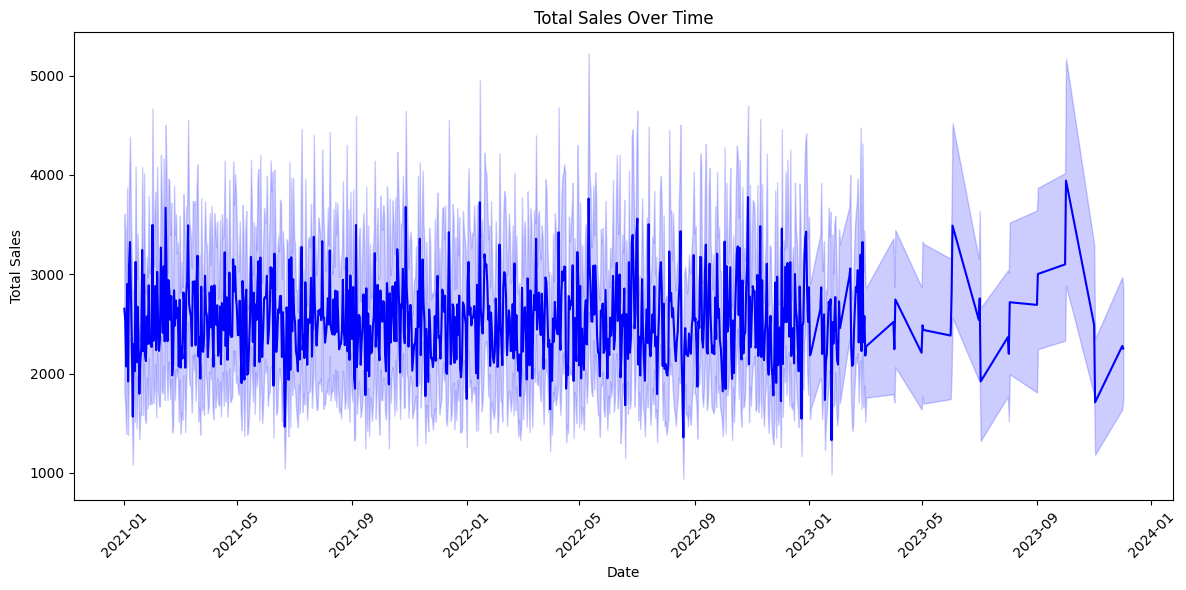

In [93]:
# Plotting the Total Sales over Time:
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_merged_df, x='Date', y='total_spend', color='b')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [59]:
print(final_merged_df['Date'].max())
print(final_merged_df['Date'].min())

2023-12-02 00:00:00
2021-01-01 00:00:00


In [60]:
df4 = final_merged_df[final_merged_df['Date']=='2023']

In [61]:
df4.count()

invoice_no           137
customer_id          137
category             137
quantity             137
Date                 137
price                137
shopping_mall        137
gender               137
age                  137
payment_method       137
construction_year    137
mall_area            137
location             137
store_count          137
Holiday              137
Special_Events       137
Has_Special_Event    137
tempmax              137
tempmin              137
temp                 137
humidity             137
icon                 137
Latitude             137
Longitude            137
total_spend          137
is_weekend           137
month                137
weekday              137
quarter              137
dtype: int64

From the above graph we do no have much data present uptil March of 2023, so we make a subset of the main dataset from the date 2021-01-01 till 2023-03-31

In [62]:
# Create a subset of the data
df_subset = final_merged_df[(final_merged_df['Date'] >= '2021-01-01') & (final_merged_df['Date'] <= '2023-04-30')]

# Display the first few rows of the filtered data
df_subset.head()

,invoice_no,customer_id,category,quantity,Date,price,shopping_mall,gender,age,payment_method,...,temp,humidity,icon,Latitude,Longitude,total_spend,is_weekend,month,weekday,quarter
0,I138884,C241288,Clothing,5,2022-05-08,1500.40,South Coast Plaza,Female,28.0,Credit Card,...,55.0,48.6,rain,33.690633,-117.889233,7502.00,1,5,6,2
1,I317333,C111565,Shoes,3,2021-12-12,1800.51,Beverly Center,Male,21.0,Debit Card,...,48.3,84.9,rain,34.074921,-118.377518,5401.53,1,12,6,4
2,I127801,C266599,Clothing,1,2021-09-11,300.08,Westfield Century City,Male,20.0,Cash,...,74.1,54.4,clear-day,34.058601,-118.418999,300.08,1,9,5,3
3,I173702,C988172,Shoes,5,2021-05-16,3000.85,Stanford Shopping Center,Female,66.0,Credit Card,...,60.9,67.0,clear-day,37.441925,-122.171928,15004.25,1,5,6,2
4,I337046,C189076,Books,4,2021-10-24,60.60,South Coast Plaza,Female,53.0,Cash,...,56.7,94.7,rain,33.690633,-117.889233,242.40,1,10,6,4


In [63]:
df_subset.count()

invoice_no           92289
customer_id          92289
category             92289
quantity             92289
Date                 92289
price                92289
shopping_mall        92289
gender               92289
age                  92289
payment_method       92289
construction_year    92289
mall_area            92289
location             92289
store_count          92289
Holiday              92289
Special_Events       92289
Has_Special_Event    92289
tempmax              92289
tempmin              92289
temp                 92289
humidity             92289
icon                 92289
Latitude             92289
Longitude            92289
total_spend          92289
is_weekend           92289
month                92289
weekday              92289
quarter              92289
dtype: int64

In [64]:
df_subset.columns

Index(['invoice_no', 'customer_id', 'category', 'quantity', 'Date', 'price',
       'shopping_mall', 'gender', 'age', 'payment_method', 'construction_year',
       'mall_area', 'location', 'store_count', 'Holiday', 'Special_Events',
       'Has_Special_Event', 'tempmax', 'tempmin', 'temp', 'humidity', 'icon',
       'Latitude', 'Longitude', 'total_spend', 'is_weekend', 'month',
       'weekday', 'quarter'],
      dtype='object')

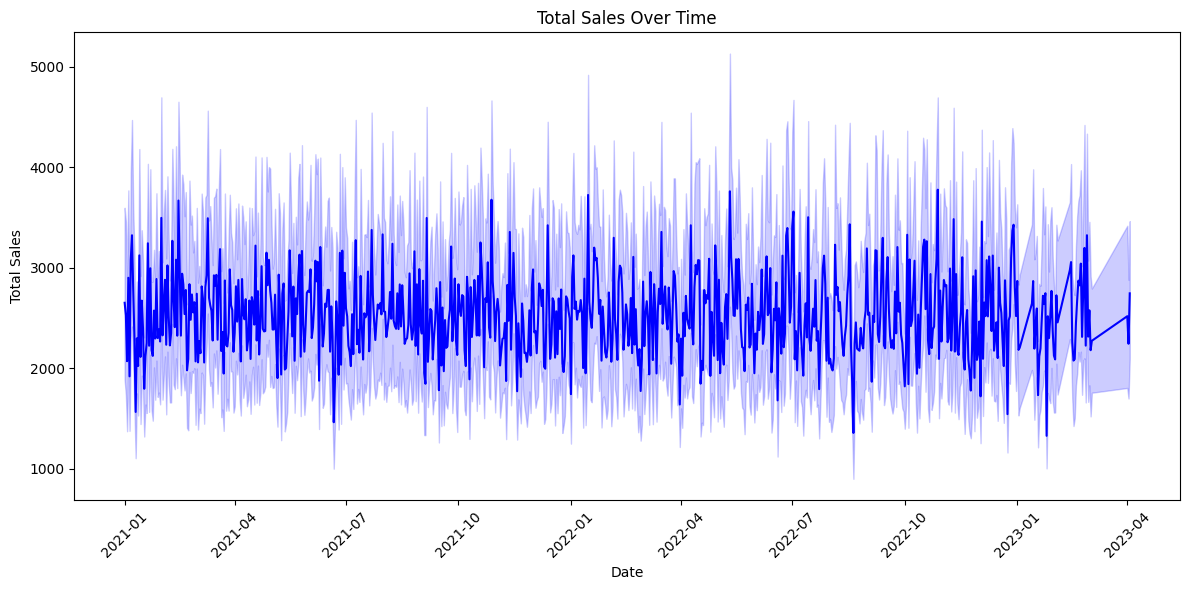

In [65]:
# Plotting the Total Sales over Time:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_subset, x='Date', y='total_spend', color='b')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\Raheb\AppData\Local\Temp\ipykernel_88732\1688525011.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mall_sales_customers = df_subset.groupby('shopping_mall').agg(
C:\Users\Raheb\AppData\Local\Temp\ipykernel_88732\1688525011.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=mall_sales_customers, x='shopping_mall', y='avg_spent_per_customer', palette='viridis')


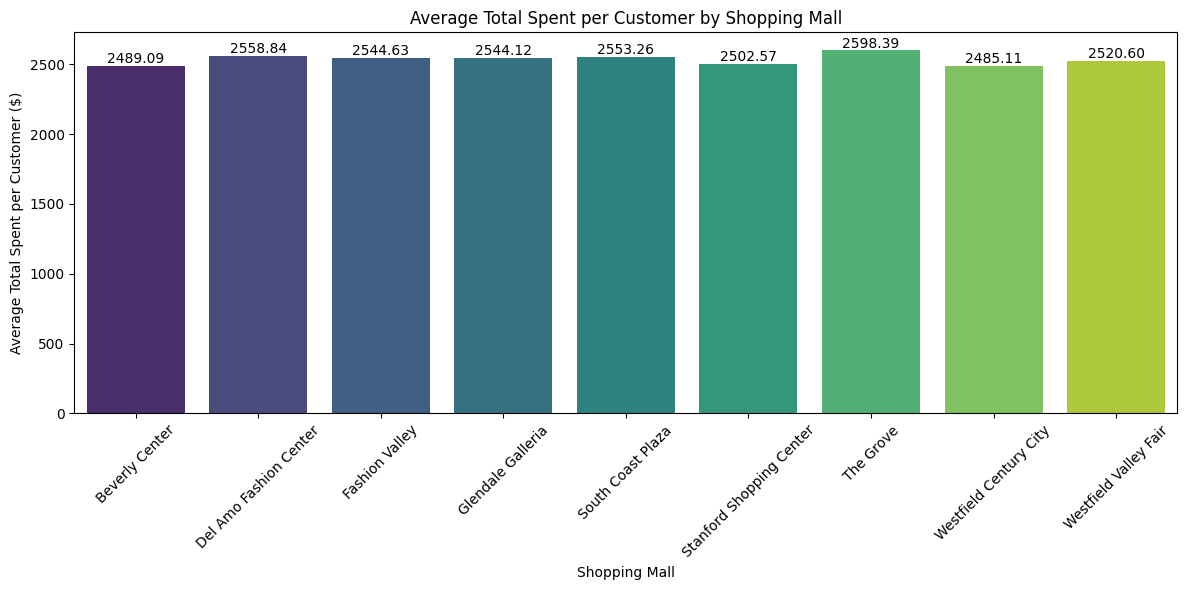

In [66]:
# Plotting the average money in dollars spent across shopping malls.
# Group by shopping mall and calculate total sales and number of unique customers
mall_sales_customers = df_subset.groupby('shopping_mall').agg(
    total_sales=('total_spend', 'sum'),
    unique_customers=('customer_id', 'nunique')
).reset_index()

# Calculate the average total spent per customer for each mall
mall_sales_customers['avg_spent_per_customer'] = mall_sales_customers['total_sales'] / mall_sales_customers['unique_customers']
    
# Plot the average total spent per customer by shopping mall
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=mall_sales_customers, x='shopping_mall', y='avg_spent_per_customer', palette='viridis')
plt.title('Average Total Spent per Customer by Shopping Mall')
plt.xlabel('Shopping Mall')
plt.ylabel('Average Total Spent per Customer ($)')
plt.xticks(rotation=45)

# Adding the values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

C:\Users\Raheb\AppData\Local\Temp\ipykernel_88732\3399834753.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_sales = df_subset.groupby(['shopping_mall', 'category'])['total_spend'].sum().unstack().fillna(0)


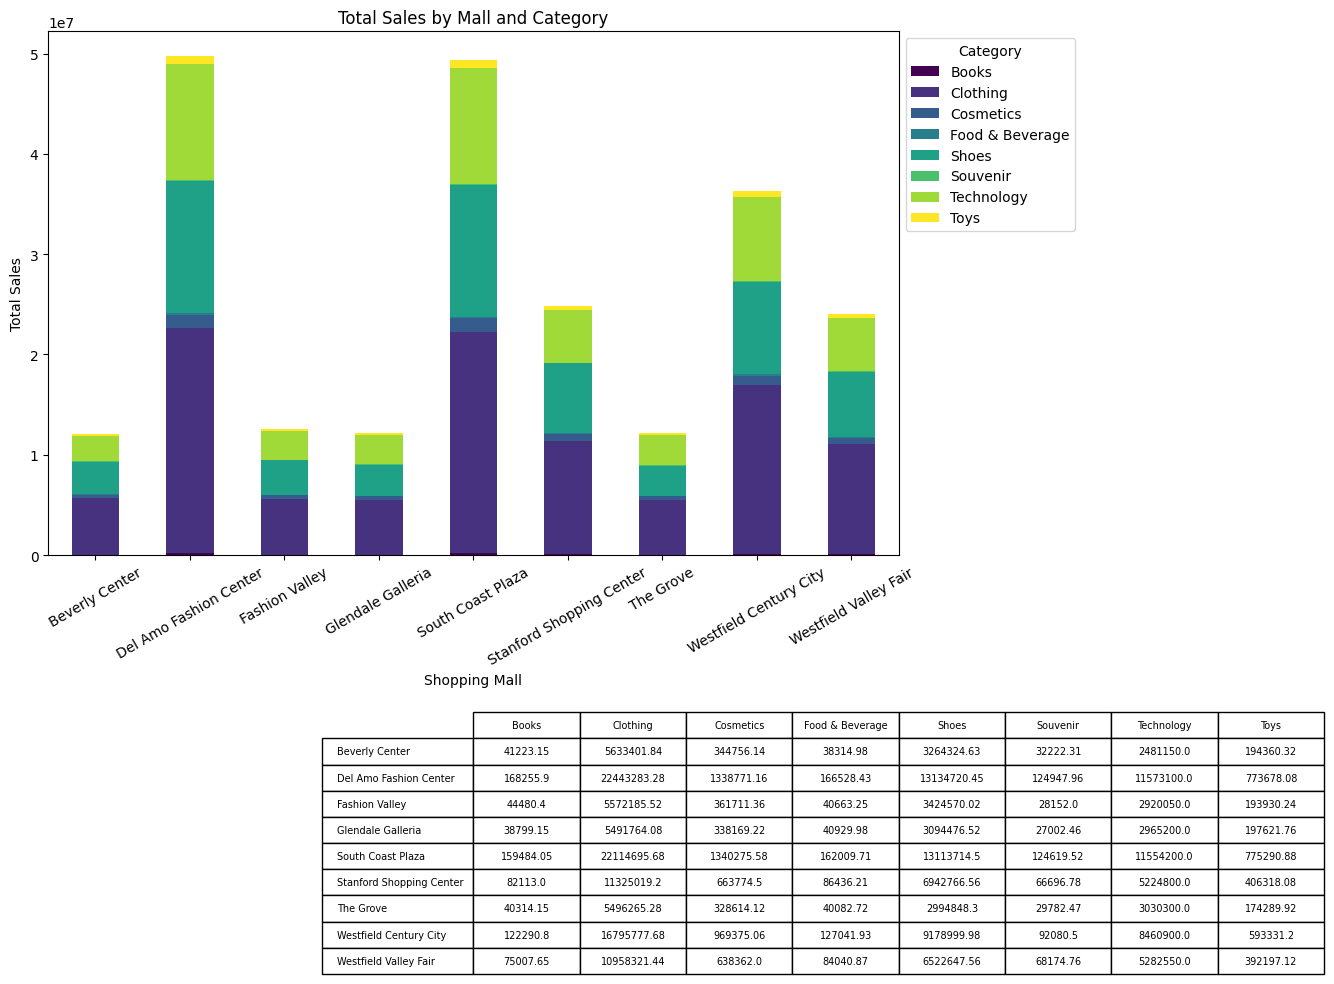

In [67]:
# Aggregating total sales by shopping mall and category
category_sales = df_subset.groupby(['shopping_mall', 'category'])['total_spend'].sum().unstack().fillna(0)

# Plotting the stacked bar chart
category_sales.plot(kind='bar', stacked=True, figsize=(15, 15), colormap='viridis')

# Creating a table below the chart
table_data = category_sales.round(2)  # Round for better readability
table = plt.table(cellText=table_data.values,
                  colLabels=table_data.columns,
                  rowLabels=table_data.index,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0.5, -0.8, 1, 0.5])

# Customize plot
plt.title('Total Sales by Mall and Category')
plt.xlabel('Shopping Mall')
plt.ylabel('Total Sales')
plt.xticks(rotation=30)
plt.tight_layout()
plt.legend(title='Category', bbox_to_anchor=(1, 1), loc='upper left')  # Place legend outside the plot
plt.show()

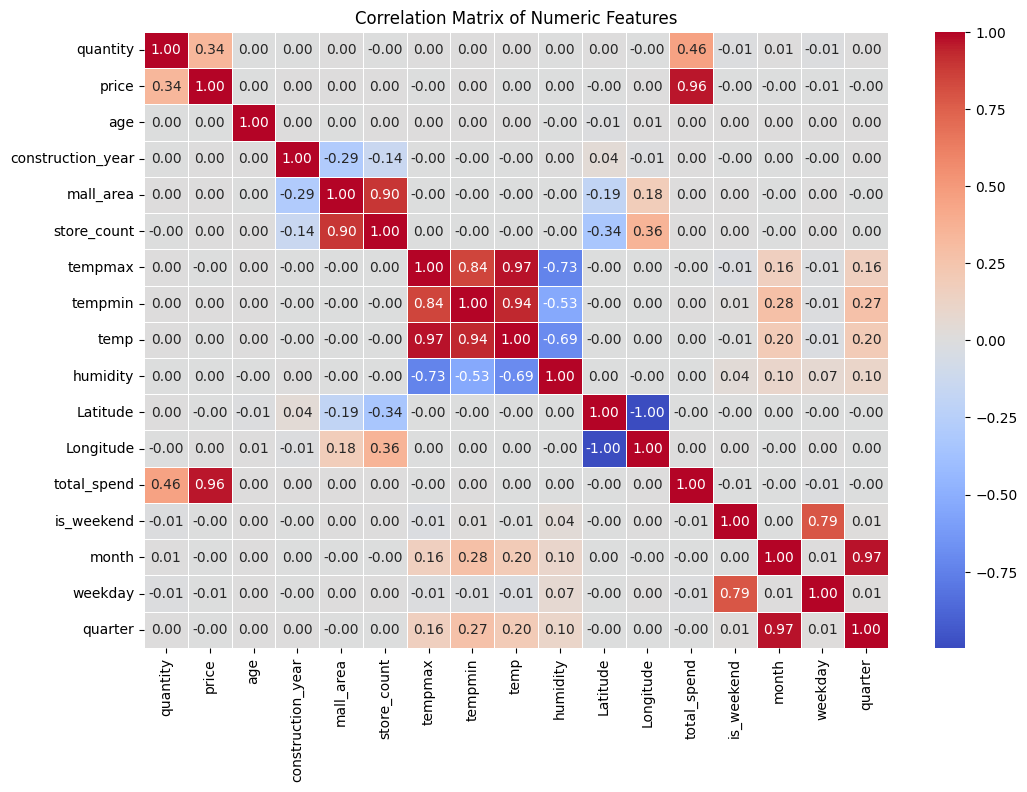

In [68]:
# Correlation Analysis
# Selecting only numeric columns for correlation analysis
numeric_df = df_subset.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

In [69]:
# Checking unique values in each column to encode categorical variable for correlation analysis.
# Select categorical columns
categorical_cols = df_subset.select_dtypes(include=['object', 'category', 'bool']).columns

# Print the number of unique values for each categorical column
for col in categorical_cols:
    print(f"{col}: {df_subset[col].nunique()} unique values")

invoice_no: 92062 unique values
customer_id: 92062 unique values
category: 8 unique values
shopping_mall: 9 unique values
gender: 2 unique values
payment_method: 3 unique values
location: 7 unique values
Holiday: 12 unique values
Special_Events: 10 unique values
Has_Special_Event: 2 unique values
icon: 5 unique values


In [70]:
# Creating a clone of the original Dataset to keep the final output as clean as possible
encoded_df = df_subset.copy()

In [71]:
# Step 2: Label Encoding for Binary Categorical Variables (Including gender)
# binary_cols = ['gender', 'Has_Special_Event']
# for col in binary_cols:
   # encoded_df[col] = encoded_df[col].astype('category').cat.codes  # Convert Yes/No or Male/Female to 0/1

# Step 3: One-Hot Encoding for Nominal Categorical Variables (Ensure gender is preserved as part of the dataset)
#one_hot_cols = ['category', 'shopping_mall', 'payment_method', 'location', 'Holiday', 'Special_Events', 'icon', 'gender', 'Has_Special_Event']
#encoded_df = pd.get_dummies(encoded_df, columns=one_hot_cols, drop_first=True)  # Drop first column to avoid multicollinearity

In [72]:
# Step 1: One-Hot Encoding for All Categorical Variables
categorical_cols = ['gender', 'Has_Special_Event', 'category', 'shopping_mall', 
                    'payment_method', 'location', 'Holiday', 'Special_Events', 'icon']

# Ensure only existing columns are used for encoding
existing_categorical_cols = [col for col in categorical_cols if col in encoded_df.columns]

# Perform one-hot encoding on all categorical variables
encoded_df = pd.get_dummies(encoded_df, columns=existing_categorical_cols, drop_first=True)

# Verify the new encoded dataset
print("Columns after encoding:")
print(encoded_df.columns)

Columns after encoding:
Index(['invoice_no', 'customer_id', 'quantity', 'Date', 'price', 'age',
       'construction_year', 'mall_area', 'store_count', 'tempmax', 'tempmin',
       'temp', 'humidity', 'Latitude', 'Longitude', 'total_spend',
       'is_weekend', 'month', 'weekday', 'quarter', 'gender_Male',
       'Has_Special_Event_True', 'category_Clothing', 'category_Cosmetics',
       'category_Food & Beverage', 'category_Shoes', 'category_Souvenir',
       'category_Technology', 'category_Toys',
       'shopping_mall_Del Amo Fashion Center', 'shopping_mall_Fashion Valley',
       'shopping_mall_Glendale Galleria', 'shopping_mall_South Coast Plaza',
       'shopping_mall_Stanford Shopping Center', 'shopping_mall_The Grove',
       'shopping_mall_Westfield Century City',
       'shopping_mall_Westfield Valley Fair', 'payment_method_Credit Card',
       'payment_method_Debit Card', 'location_Glendale',
       'location_Los Angeles', 'location_Palo Alto', 'location_San Diego',
       '

In [73]:
# Checking if each category was encoded correctly by summing up values in each column
encoded_cols = [col for col in encoded_df.columns if col.startswith(('category_', 'shopping_mall_', 'gender_', 
                                                                     'payment_method_', 'location_', 'Holiday_', 
                                                                     'Special_Events_', 'icon_'))]

# Summarizing the count of each encoded variable
encoding_summary = encoded_df[encoded_cols].sum().sort_values(ascending=False)
print(encoding_summary)

Special_Events_No Event                         90132
Holiday_No Holiday                              89341
gender_Male                                     37049
payment_method_Credit Card                      32389
category_Clothing                               32018
location_Los Angeles                            24184
shopping_mall_Del Amo Fashion Center            19489
location_Torrance                               19489
shopping_mall_South Coast Plaza                 19367
payment_method_Debit Card                       18692
shopping_mall_Westfield Century City            14654
category_Cosmetics                              14046
icon_partly-cloudy-day                          13828
category_Food & Beverage                        13665
icon_rain                                       13641
shopping_mall_Stanford Shopping Center           9929
location_Palo Alto                               9929
shopping_mall_Westfield Valley Fair              9558
location_Santa Clara        

In [74]:
print(encoded_df.dtypes)

invoice_no                                object
customer_id                               object
quantity                                   int64
Date                              datetime64[ns]
price                                    float64
                                       ...      
Special_Events_Valentine's Day              bool
icon_cloudy                                 bool
icon_partly-cloudy-day                      bool
icon_rain                                   bool
icon_wind                                   bool
Length: 69, dtype: object


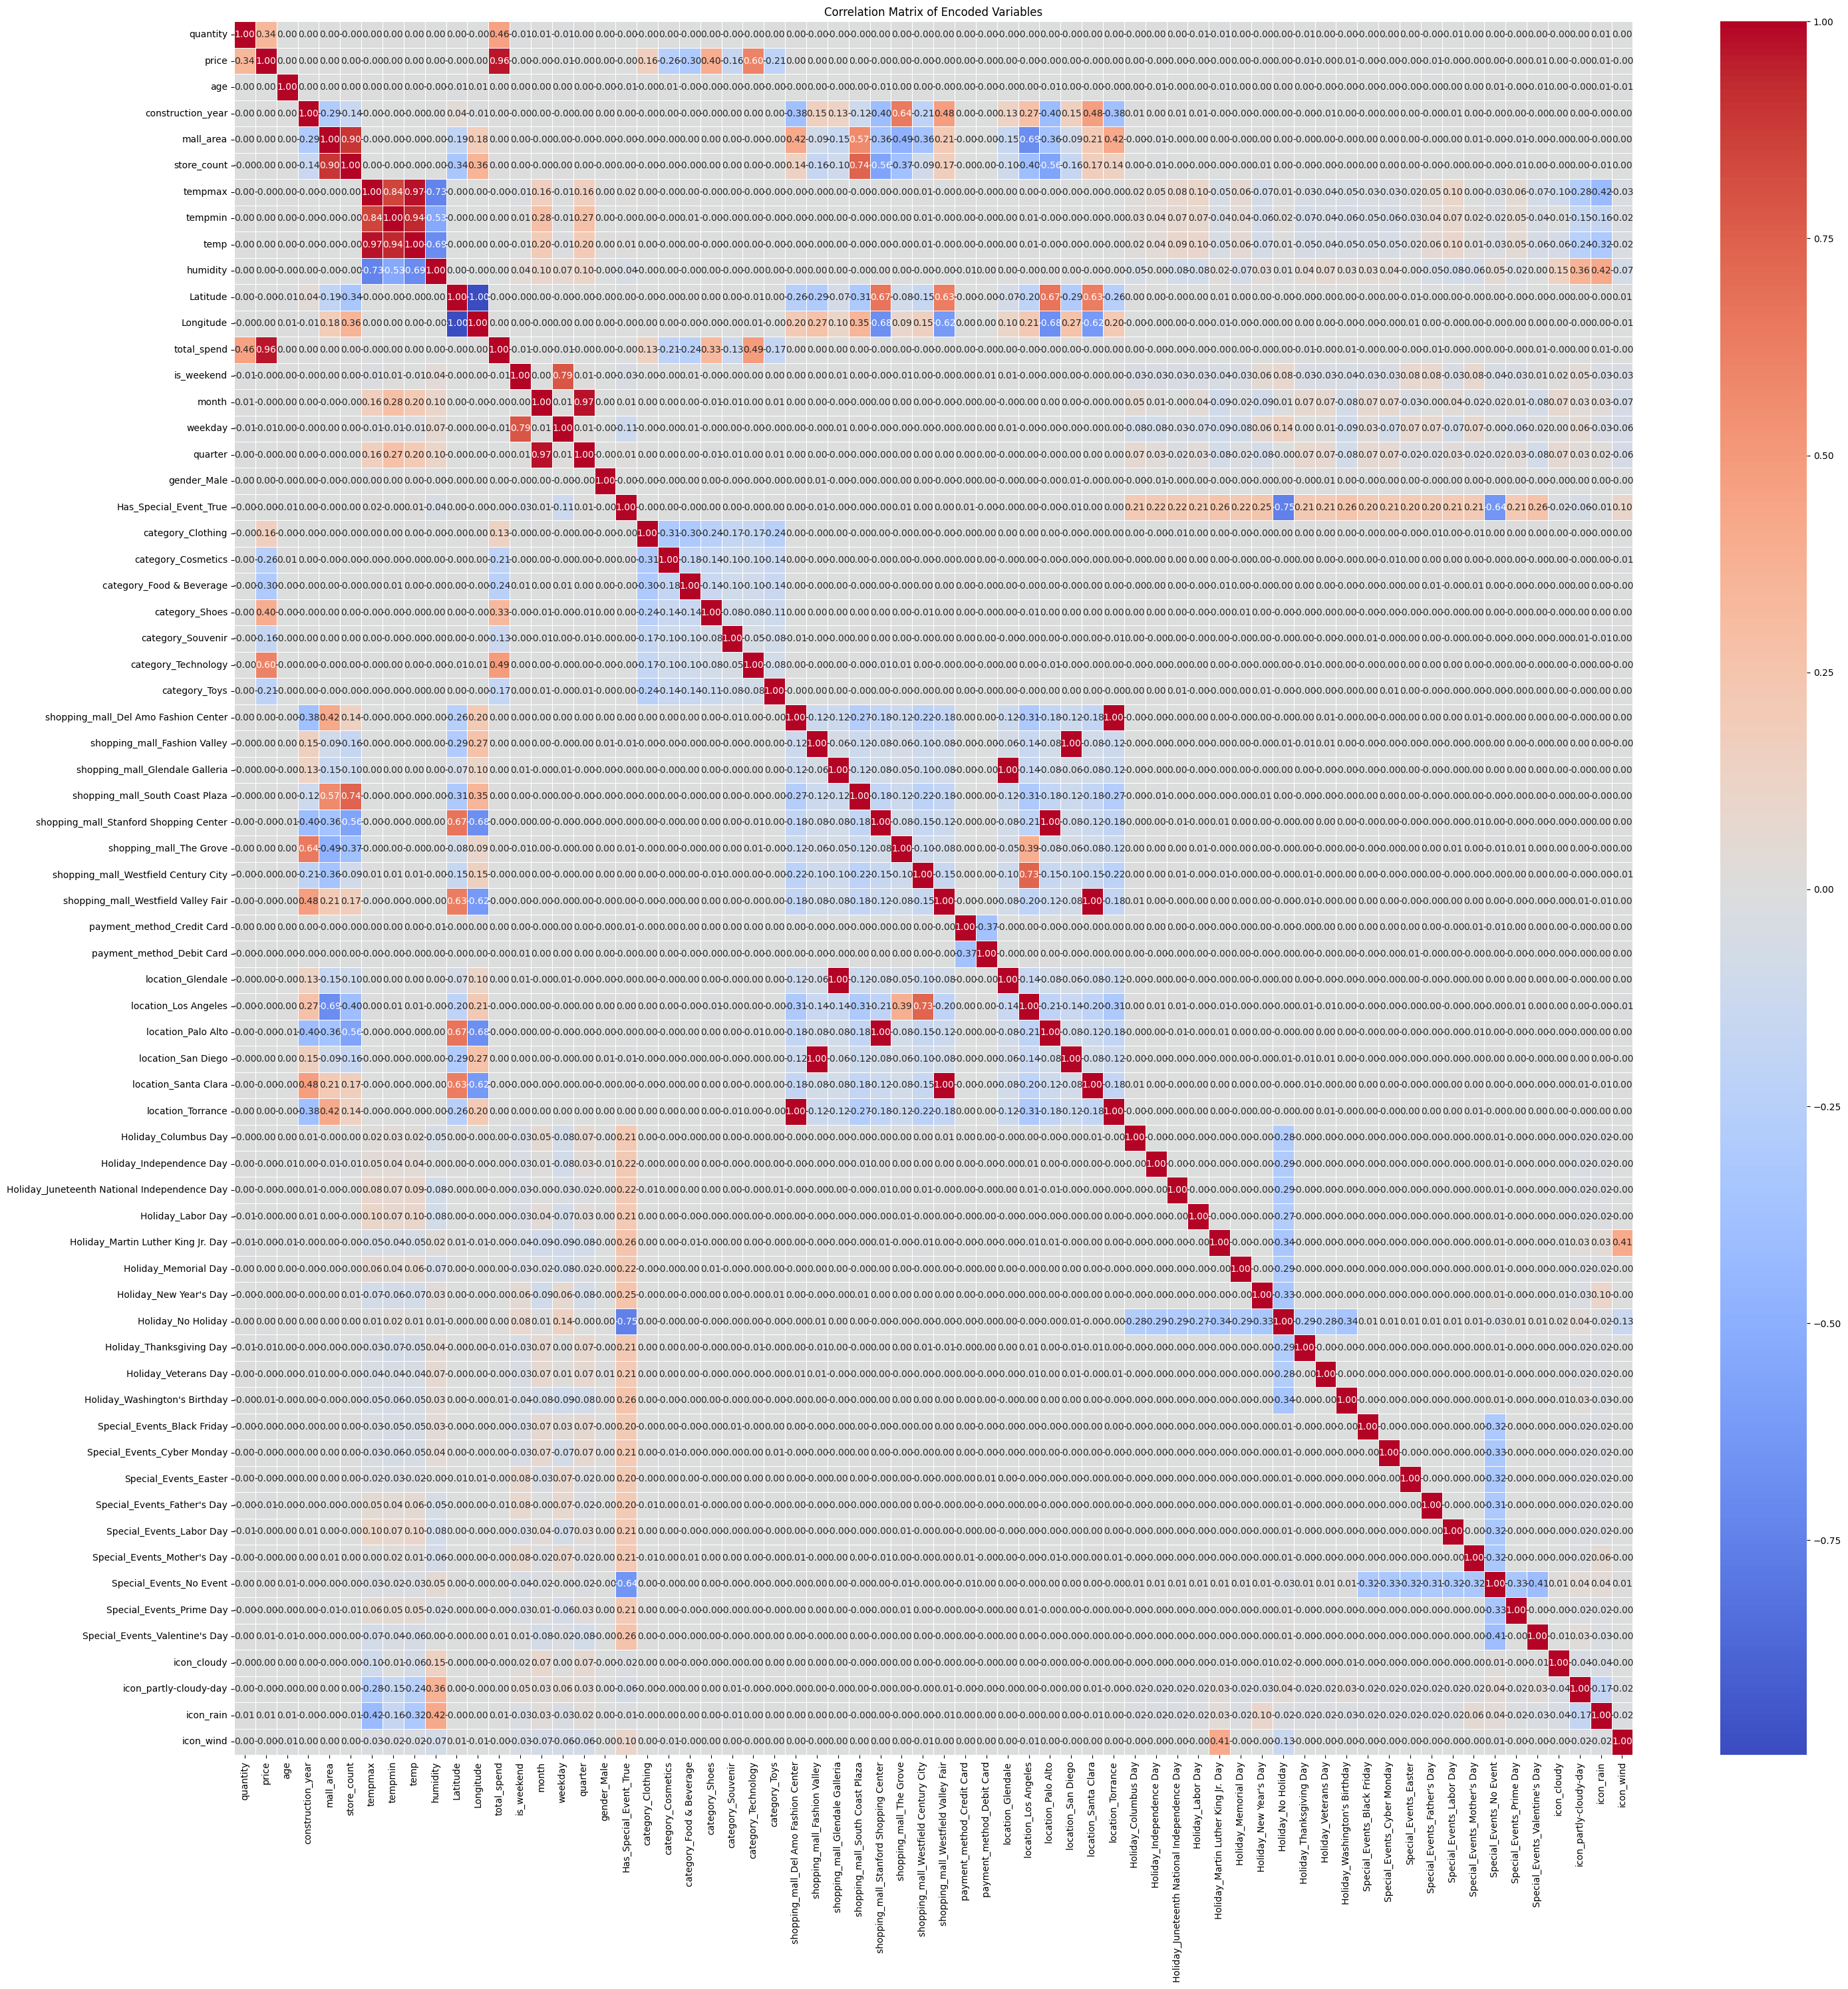

In [75]:
# Select numeric and boolean (encoded) columns for correlation analysis
encoded_columns = encoded_df.select_dtypes(include=['int32', 'int64', 'float64', 'bool']).columns

# Compute the correlation matrix for the encoded variables
correlation_matrix_encoded = encoded_df[encoded_columns].corr()

# Plotting the correlation matrix using a heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix_encoded, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Encoded Variables')
plt.tight_layout()
plt.show()

In [76]:
print(correlation_matrix_encoded)

                                quantity     price       age  \
quantity                        1.000000  0.343974  0.001273   
price                           0.343974  1.000000  0.000807   
age                             0.001273  0.000807  1.000000   
construction_year               0.001216  0.001760  0.001469   
mall_area                       0.001664  0.001793  0.000934   
...                                  ...       ...       ...   
Special_Events_Valentine's Day  0.003491  0.006848 -0.005237   
icon_cloudy                    -0.001229  0.000039  0.000736   
icon_partly-cloudy-day          0.000459 -0.000215 -0.002931   
icon_rain                       0.006144  0.005433  0.005133   
icon_wind                       0.000757 -0.000282 -0.007973   

                                construction_year  mall_area  store_count  \
quantity                                 0.001216   0.001664    -0.000394   
price                                    0.001760   0.001793     0.001424   


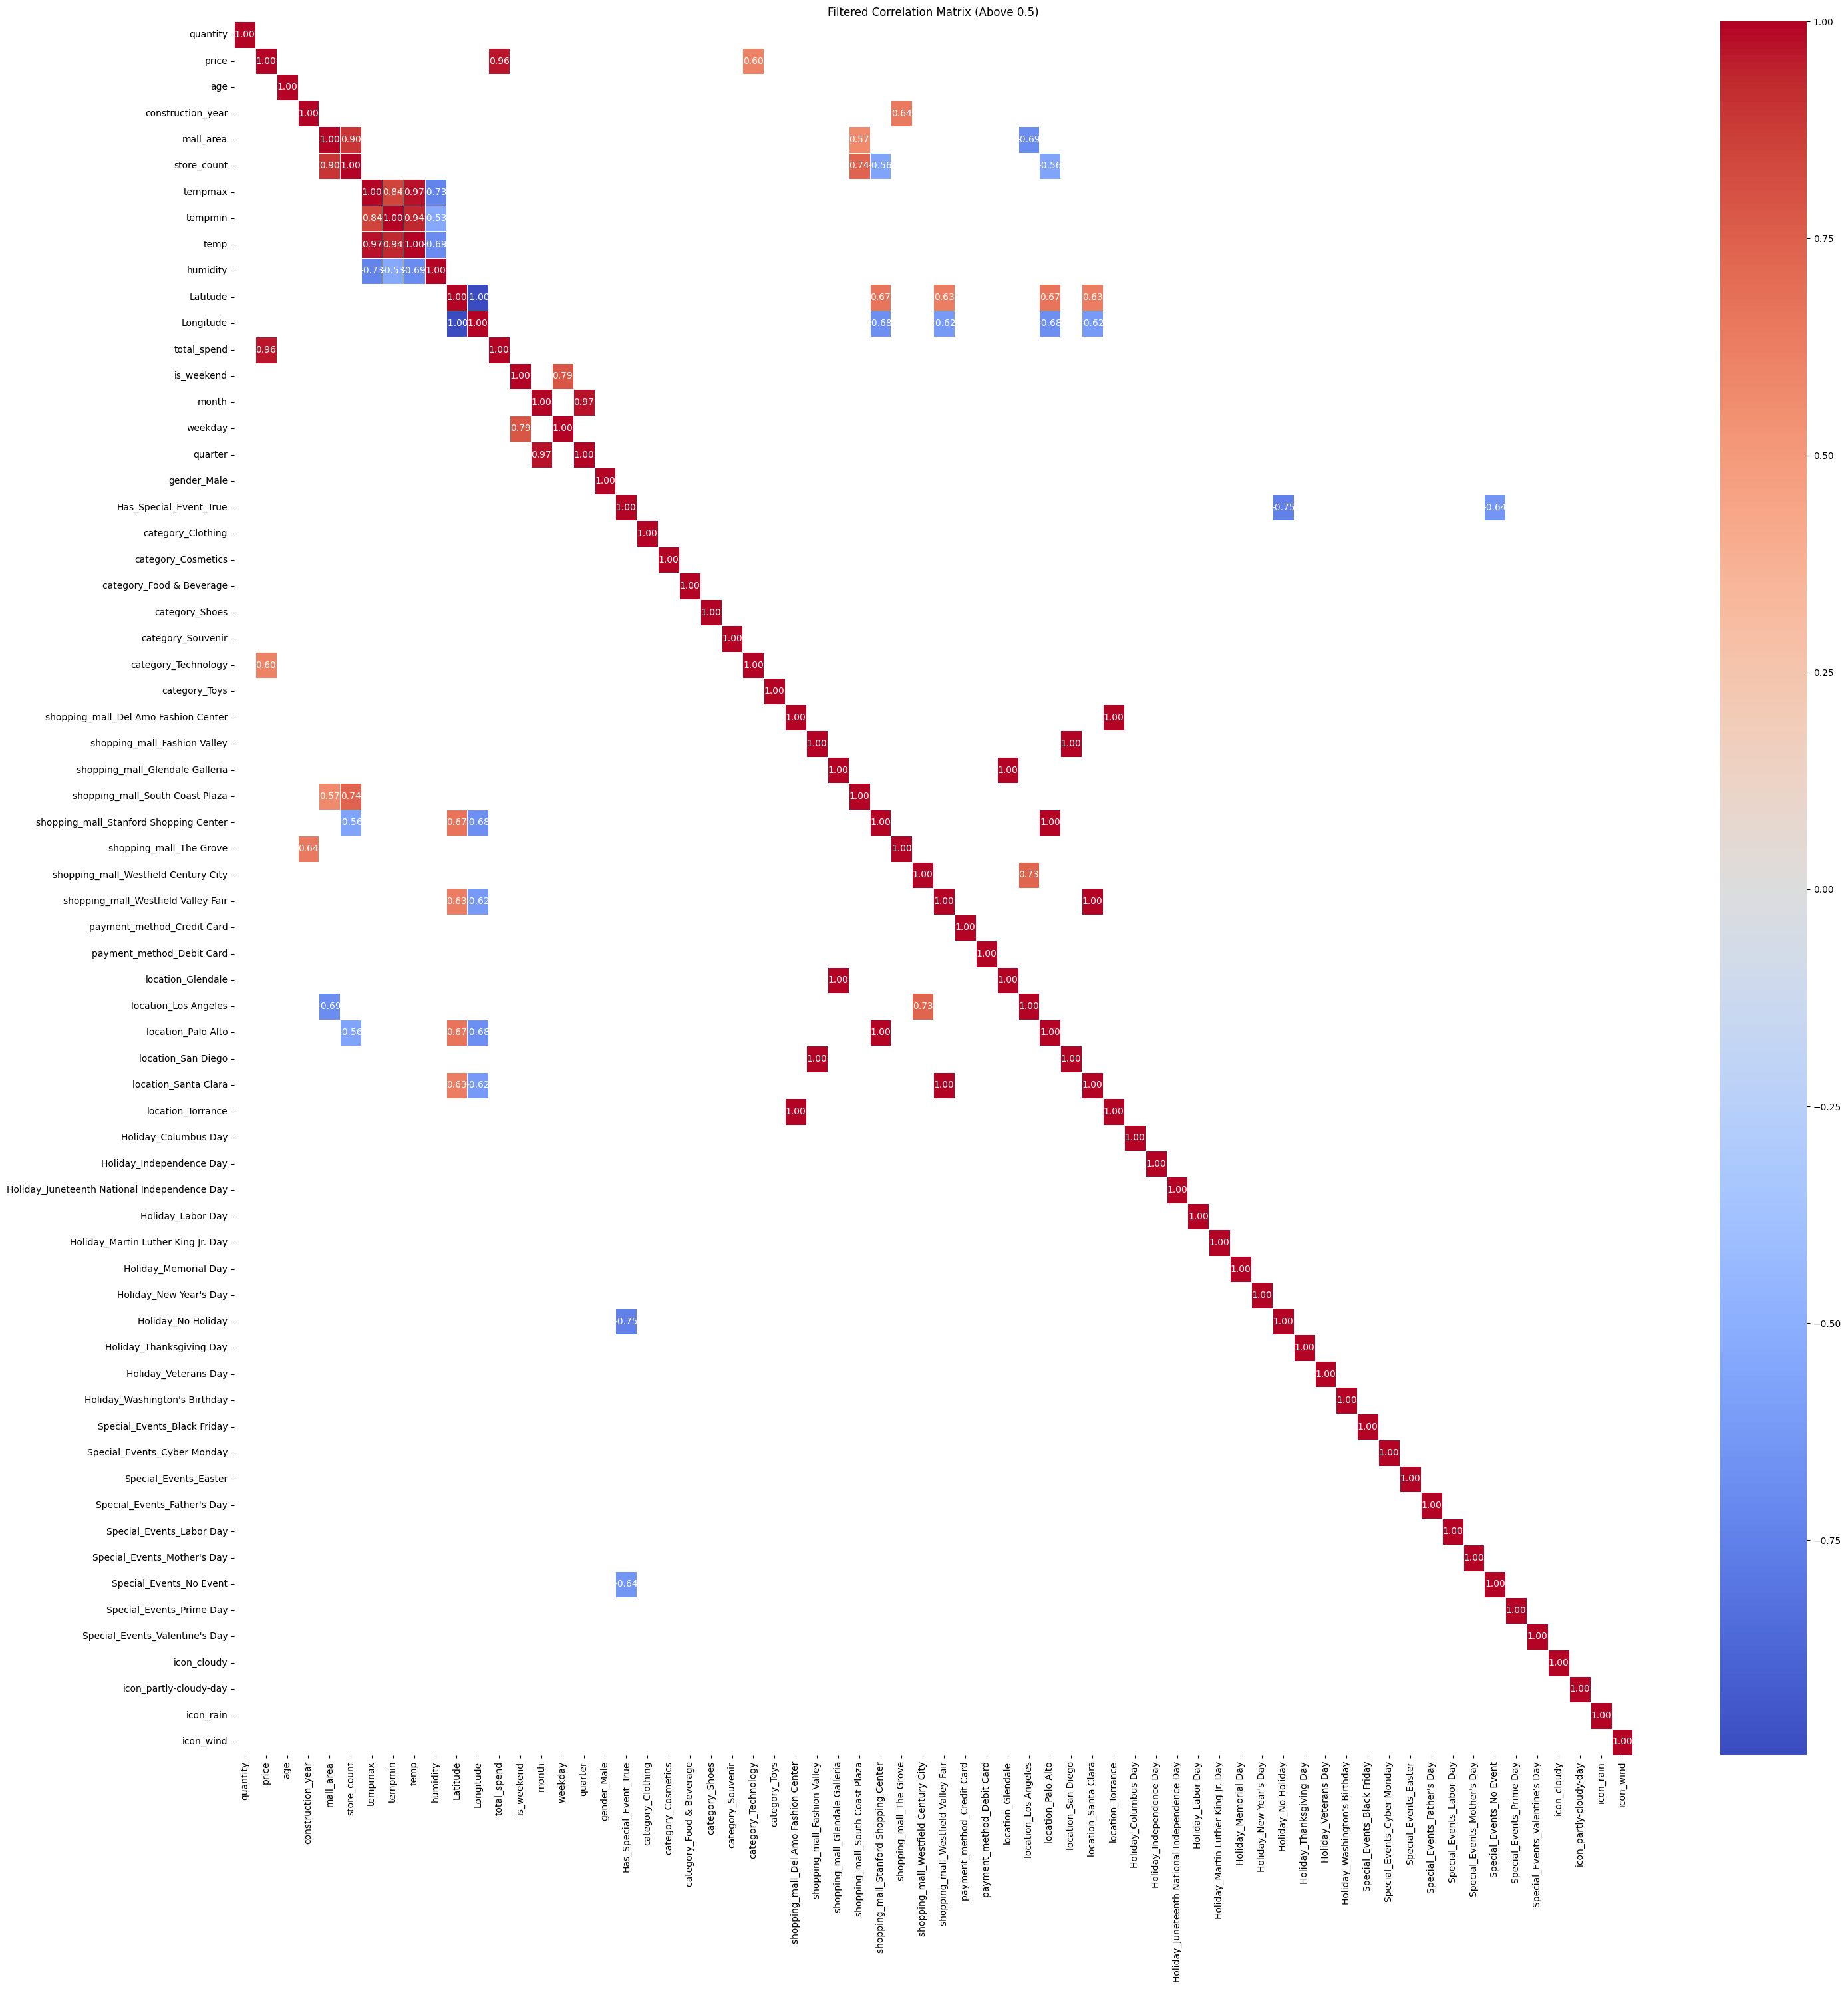

In [77]:
# Set a correlation threshold to highlight strong correlations
threshold = 0.5
high_corr_matrix = correlation_matrix_encoded[abs(correlation_matrix_encoded) > threshold]

# Mask the values below the threshold for clarity
mask = abs(correlation_matrix_encoded) <= threshold
masked_corr_matrix = correlation_matrix_encoded.mask(mask)

# Plot the correlation matrix for high correlations
plt.figure(figsize=(30, 30))
sns.heatmap(masked_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Filtered Correlation Matrix (Above 0.5)')
plt.tight_layout()
plt.show()

In [78]:
# Set the correlation threshold
threshold = 0.5

# Mask correlations below the threshold (excluding the diagonal)
filtered_corr = correlation_matrix_encoded.applymap(lambda x: x if abs(x) >= threshold else np.nan)

# Optionally, if you want to see positive or negative correlations separately:
# Positive correlations above the threshold
positive_corr = filtered_corr[filtered_corr > threshold]

# Negative correlations below the negative threshold
negative_corr = filtered_corr[filtered_corr < -threshold]

# Display the filtered correlation matrix
print("Filtered Correlation Matrix (Threshold > 0.5):")
print(filtered_corr)

# Display positive correlations
print("\nPositive Correlations (Threshold > 0.5):")
print(positive_corr)

# Display negative correlations
print("\nNegative Correlations (Threshold < -0.5):")
print(negative_corr)

# Flatten the correlation matrix and sort values
sorted_corr = filtered_corr.stack().sort_values(ascending=False)

Filtered Correlation Matrix (Threshold > 0.5):
                                quantity  price  age  construction_year  \
quantity                             1.0    NaN  NaN                NaN   
price                                NaN    1.0  NaN                NaN   
age                                  NaN    NaN  1.0                NaN   
construction_year                    NaN    NaN  NaN                1.0   
mall_area                            NaN    NaN  NaN                NaN   
...                                  ...    ...  ...                ...   
Special_Events_Valentine's Day       NaN    NaN  NaN                NaN   
icon_cloudy                          NaN    NaN  NaN                NaN   
icon_partly-cloudy-day               NaN    NaN  NaN                NaN   
icon_rain                            NaN    NaN  NaN                NaN   
icon_wind                            NaN    NaN  NaN                NaN   

                                mall_area  store_cou

C:\Users\Raheb\AppData\Local\Temp\ipykernel_88732\2647496293.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  filtered_corr = correlation_matrix_encoded.applymap(lambda x: x if abs(x) >= threshold else np.nan)


In [79]:
# Convert correlation matrix to DataFrame
corr_df = correlation_matrix_encoded.stack().reset_index()
corr_df.columns = ['Feature_1', 'Feature_2', 'Correlation']

# Display the first few rows
print(corr_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4356 entries, 0 to 4355
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature_1    4356 non-null   object 
 1   Feature_2    4356 non-null   object 
 2   Correlation  4356 non-null   float64
dtypes: float64(1), object(2)
memory usage: 102.2+ KB
None


In [80]:
# Remove self-correlations (where Feature_1 == Feature_2)
corr_df = corr_df[corr_df['Feature_1'] != corr_df['Feature_2']]

# Sort by absolute correlation values (highest correlations first)
corr_df = corr_df.sort_values(by='Correlation', ascending=False)

# Display the cleaned correlation table
print(corr_df.head(10))  # View top correlations

                                   Feature_1  \
2018  shopping_mall_Stanford Shopping Center   
2732                       location_Torrance   
2601                      location_San Diego   
2404                       location_Glendale   
2673                    location_Santa Clara   
1821            shopping_mall_Fashion Valley   
1884         shopping_mall_Glendale Galleria   
2538                      location_Palo Alto   
1757    shopping_mall_Del Amo Fashion Center   
2218     shopping_mall_Westfield Valley Fair   

                                   Feature_2  Correlation  
2018                      location_Palo Alto          1.0  
2732    shopping_mall_Del Amo Fashion Center          1.0  
2601            shopping_mall_Fashion Valley          1.0  
2404         shopping_mall_Glendale Galleria          1.0  
2673     shopping_mall_Westfield Valley Fair          1.0  
1821                      location_San Diego          1.0  
1884                       location_Glendale       

In [81]:
corr_df.head(10)  

,Feature_1,Feature_2,Correlation
2018,shopping_mall_Stanford Shopping Center,location_Palo Alto,1.0
2732,location_Torrance,shopping_mall_Del Amo Fashion Center,1.0
2601,location_San Diego,shopping_mall_Fashion Valley,1.0
2404,location_Glendale,shopping_mall_Glendale Galleria,1.0
2673,location_Santa Clara,shopping_mall_Westfield Valley Fair,1.0
1821,shopping_mall_Fashion Valley,location_San Diego,1.0
1884,shopping_mall_Glendale Galleria,location_Glendale,1.0
2538,location_Palo Alto,shopping_mall_Stanford Shopping Center,1.0
1757,shopping_mall_Del Amo Fashion Center,location_Torrance,1.0
2218,shopping_mall_Westfield Valley Fair,location_Santa Clara,1.0


In [82]:
# Remove perfect correlations (corr = 1.0)
corr_df = corr_df[corr_df['Correlation'] < 1.0]

# Sort by absolute correlation
corr_df = corr_df.sort_values(by='Correlation', ascending=False)

# Display cleaned correlations
print(corr_df.head(10))

        Feature_1    Feature_2  Correlation
1070      quarter        month     0.972861
940         month      quarter     0.972861
404       tempmax         temp     0.971832
534          temp      tempmax     0.971832
793   total_spend        price     0.962186
78          price  total_spend     0.962186
535          temp      tempmin     0.937426
470       tempmin         temp     0.937426
269     mall_area  store_count     0.897731
334   store_count    mall_area     0.897731


In [83]:
# Filter correlations where 'Feature_1' or 'Feature_2' is 'total_spend'
total_spend_corr = corr_df[
    (corr_df['Feature_1'] == 'total_spend') | (corr_df['Feature_2'] == 'total_spend')
]

# Sort by absolute correlation value
total_spend_corr = total_spend_corr.sort_values(by='Correlation', ascending=False)

# Display top correlated features with total_spend
print(total_spend_corr.head(10))

                Feature_1            Feature_2  Correlation
793           total_spend                price     0.962186
78                  price          total_spend     0.962186
816           total_spend  category_Technology     0.491222
1596  category_Technology          total_spend     0.491222
12               quantity          total_spend     0.460798
792           total_spend             quantity     0.460798
1464       category_Shoes          total_spend     0.326572
814           total_spend       category_Shoes     0.326572
811           total_spend    category_Clothing     0.134694
1266    category_Clothing          total_spend     0.134694


# As the correlation matrix was not very helpful for insights we move onto regression analysis

In [84]:
# Regression Analysis:

In [85]:
# Check the data types of all columns
print(encoded_df.dtypes.value_counts())

# Display non-numeric columns
non_numeric_cols = encoded_df.select_dtypes(exclude=['number']).columns
print("\nNon-Numeric Columns:\n", non_numeric_cols)

bool              49
float64           12
int32              4
object             2
int64              1
datetime64[ns]     1
Name: count, dtype: int64

Non-Numeric Columns:
 Index(['invoice_no', 'customer_id', 'Date', 'gender_Male',
       'Has_Special_Event_True', 'category_Clothing', 'category_Cosmetics',
       'category_Food & Beverage', 'category_Shoes', 'category_Souvenir',
       'category_Technology', 'category_Toys',
       'shopping_mall_Del Amo Fashion Center', 'shopping_mall_Fashion Valley',
       'shopping_mall_Glendale Galleria', 'shopping_mall_South Coast Plaza',
       'shopping_mall_Stanford Shopping Center', 'shopping_mall_The Grove',
       'shopping_mall_Westfield Century City',
       'shopping_mall_Westfield Valley Fair', 'payment_method_Credit Card',
       'payment_method_Debit Card', 'location_Glendale',
       'location_Los Angeles', 'location_Palo Alto', 'location_San Diego',
       'location_Santa Clara', 'location_Torrance', 'Holiday_Columbus Day',
      

In [86]:
# Drop irrelevant columns (IDs and Date)
encoded_df = encoded_df.drop(columns=['invoice_no', 'customer_id', 'Date'], errors='ignore')

# Convert boolean columns to integer (0/1)
bool_cols = encoded_df.select_dtypes(include=['bool']).columns
encoded_df[bool_cols] = encoded_df[bool_cols].astype(int)

# Check if all columns are now numeric
non_numeric_cols = encoded_df.select_dtypes(exclude=['number']).columns
print("\nRemaining Non-Numeric Columns:", non_numeric_cols)


Remaining Non-Numeric Columns: Index([], dtype='object')


In [87]:
print(encoded_df.isnull().sum().sum())  
encoded_df.describe()

0


,quantity,price,age,construction_year,mall_area,store_count,tempmax,tempmin,temp,humidity,...,Special_Events_Father's Day,Special_Events_Labor Day,Special_Events_Mother's Day,Special_Events_No Event,Special_Events_Prime Day,Special_Events_Valentine's Day,icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_wind
count,92289.000000,92289.000000,92289.000000,92289.000000,92289.000000,92289.000000,92289.000000,92289.000000,92289.000000,92289.000000,...,92289.00000,92289.000000,92289.000000,92289.000000,92289.000000,92289.000000,92289.000000,92289.000000,92289.000000,92289.000000
mean,3.004313,688.990386,43.417948,1969.611936,183132.529337,208.823045,74.675091,49.287153,60.852578,61.068132,...,0.00233,0.002460,0.002471,0.976628,0.002546,0.003922,0.007834,0.149834,0.147807,0.002557
std,1.412167,939.966735,15.005049,11.672922,60062.584027,42.532184,16.036533,9.955300,12.130889,17.195083,...,0.04821,0.049534,0.049643,0.151083,0.050397,0.062507,0.088163,0.356910,0.354911,0.050504
min,1.000000,5.230000,18.000000,1956.000000,56000.000000,140.000000,42.100000,27.600000,36.600000,18.100000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,45.450000,30.000000,1961.000000,133000.000000,180.000000,61.200000,41.000000,50.100000,48.400000,...,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,203.300000,43.000000,1967.000000,220000.000000,220.000000,73.500000,49.000000,59.700000,59.800000,...,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,1200.320000,56.000000,1977.000000,232000.000000,230.000000,88.400000,57.700000,71.600000,73.600000,...,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,5250.000000,69.000000,2002.000000,250000.000000,270.000000,114.100000,75.800000,92.400000,98.800000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Linear Regression

In [88]:
# Define target variable
y = encoded_df['total_spend']

# Define feature set (excluding target)
X = encoded_df.drop(columns=['total_spend'])

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify shapes
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (73831, 65) (73831,)
Testing set shape: (18458, 65) (18458,)


In [89]:
# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

# Model Evaluation
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = mse ** 0.5  # Root Mean Squared Error

# Print results
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

Train R²: 0.9805
Test R²: 0.9810
MAE: 366.2854
RMSE: 585.0309


Top 10 most important features:
                               Feature  Coefficient  Abs_Coefficient
23                 category_Technology -7308.818909      7308.818909
21                      category_Shoes -4108.960910      4108.960910
18                   category_Clothing -2002.734224      2002.734224
19                  category_Cosmetics  -178.608782       178.608782
24                       category_Toys  -146.557959       146.557959
53         Special_Events_Cyber Monday   134.514906       134.514906
46                Holiday_Memorial Day   104.133025       104.133025
45  Holiday_Martin Luther King Jr. Day    96.600610        96.600610
52         Special_Events_Black Friday    86.486280        86.486280
47              Holiday_New Year's Day    83.880027        83.880027


C:\Users\Raheb\AppData\Local\Temp\ipykernel_88732\1172108320.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(15), x='Coefficient', y='Feature', palette='coolwarm')


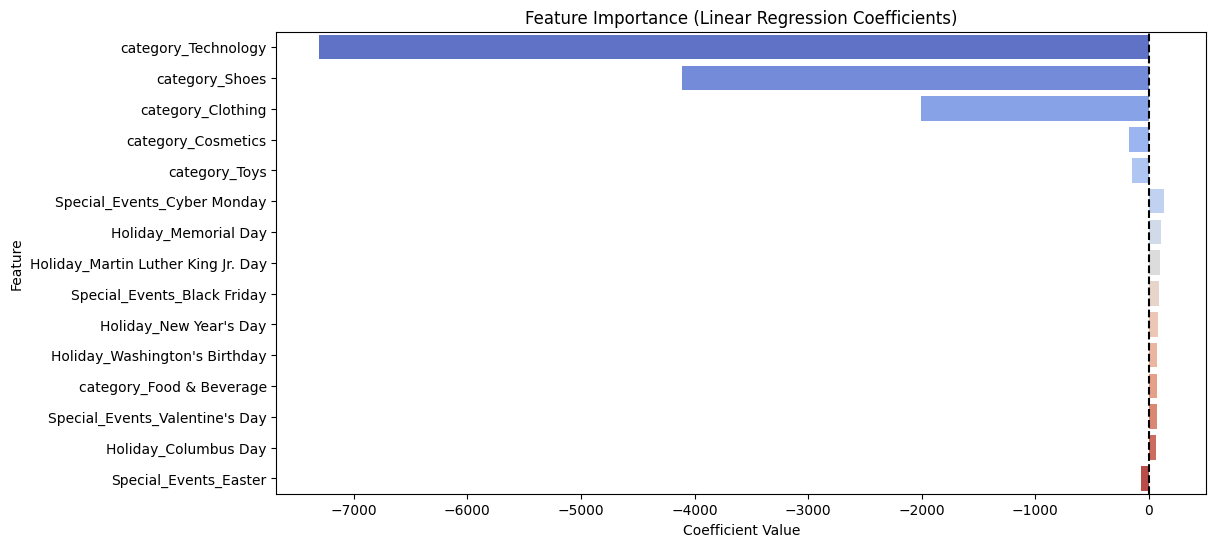

In [90]:
# Get feature importance (coefficients)
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lr_model.coef_})

# Sort by absolute coefficient values
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Display top features
print("Top 10 most important features:")
print(feature_importance.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(15), x='Coefficient', y='Feature', palette='coolwarm')
plt.axvline(0, color='black', linestyle='--')
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

## Random Forest Regressor

In [91]:
# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# Model Evaluation
train_r2_rf = r2_score(y_train, y_pred_train_rf)
test_r2_rf = r2_score(y_test, y_pred_test_rf)
mae_rf = mean_absolute_error(y_test, y_pred_test_rf)
mse_rf = mean_squared_error(y_test, y_pred_test_rf)
rmse_rf = mse_rf ** 0.5  # Root Mean Squared Error

# Print results
print(f"Train R² (Random Forest): {train_r2_rf:.4f}")
print(f"Test R² (Random Forest): {test_r2_rf:.4f}")
print(f"MAE (Random Forest): {mae_rf:.4f}")
print(f"RMSE (Random Forest): {rmse_rf:.4f}")

Train R² (Random Forest): 1.0000
Test R² (Random Forest): 1.0000
MAE (Random Forest): 0.0000
RMSE (Random Forest): 0.0000


In [92]:
# Feature Importance
importances_rf = rf_model.feature_importances_
feature_importance_df_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances_rf
}).sort_values(by='Importance', ascending=False)

# Display the top 10 important features
print("Top 10 Most Important Features (Random Forest):")
print(feature_importance_df_rf.head(10))

Top 10 Most Important Features (Random Forest):
                     Feature    Importance
1                      price  9.497847e-01
0                   quantity  4.481199e-02
23       category_Technology  1.913523e-03
18         category_Clothing  1.901079e-03
21            category_Shoes  1.574564e-03
24             category_Toys  9.937097e-06
19        category_Cosmetics  3.469348e-06
22         category_Souvenir  6.985053e-07
20  category_Food & Beverage  2.486389e-08
9                   humidity  7.376369e-16


## Segmentation Analysis using K-Means

In [101]:
print(df_subset.columns)

Index(['invoice_no', 'customer_id', 'category', 'quantity', 'Date', 'price',
       'shopping_mall', 'gender', 'age', 'payment_method', 'construction_year',
       'mall_area', 'location', 'store_count', 'Holiday', 'Special_Events',
       'Has_Special_Event', 'tempmax', 'tempmin', 'temp', 'humidity', 'icon',
       'Latitude', 'Longitude', 'total_spend', 'is_weekend', 'month',
       'weekday', 'quarter'],
      dtype='object')


In [104]:
# Numerical features to be scaled
num_features = ['total_spend', 'age', 'temp', 'store_count', 'mall_area']

# Categorical features to be encoded
cat_features = ['category', 'shopping_mall', 'payment_method', 'gender', 'location', 
                'Has_Special_Event', 'month', 'weekday', 'is_weekend']

# Select relevant columns
df_selected = df_subset[num_features + cat_features].copy()

In [105]:
# Define transformations
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformations
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

# Apply transformations
df_preprocessed = preprocessor.fit_transform(df_selected)

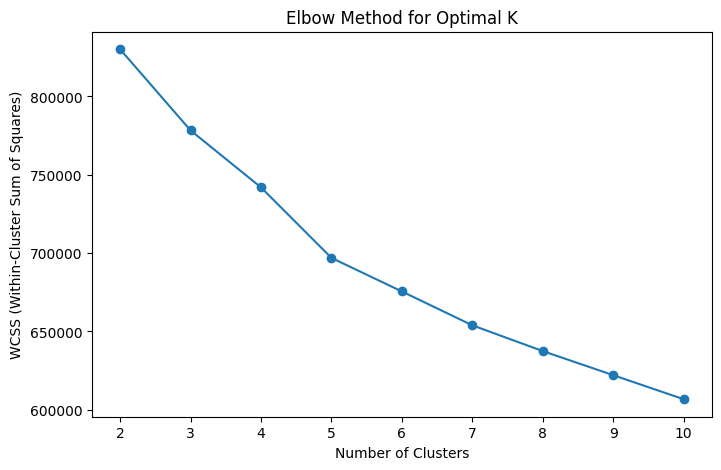

In [106]:
wcss = []
K_range = range(2, 11)  # Testing for clusters 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_preprocessed)
    wcss.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.show()

In [116]:
# Set optimal number of clusters (choose based on elbow method)
optimal_k = 5  # Adjust this based on elbow curve

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_selected['Cluster'] = kmeans.fit_predict(df_preprocessed)


In [111]:
# Printing a few rows to inspect column names
print(df_selected.head())

   total_spend   age  temp  store_count  mall_area  category  \
0      7502.00  28.0  55.0        270.0   250000.0  Clothing   
1      5401.53  21.0  48.3        160.0   111000.0     Shoes   
2       300.08  20.0  74.1        200.0   133000.0  Clothing   
3     15004.25  66.0  60.9        140.0   120000.0     Shoes   
4       242.40  53.0  56.7        270.0   250000.0     Books   

              shopping_mall payment_method  gender     location  \
0         South Coast Plaza    Credit Card  Female   Costa Mesa   
1            Beverly Center     Debit Card    Male  Los Angeles   
2    Westfield Century City           Cash    Male  Los Angeles   
3  Stanford Shopping Center    Credit Card  Female    Palo Alto   
4         South Coast Plaza           Cash  Female   Costa Mesa   

   Has_Special_Event  month  weekday  is_weekend  Cluster  
0               True      5        6           1        0  
1              False     12        6           1        1  
2              False      9     

In [117]:
# Cluster-wise summary with mode for categorical columns and mean for numerical columns
def custom_agg(df, col):
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        return df[col].mode()[0]  # Most frequent value
    return df[col].mean()

In [118]:
# Custom aggregation function
def custom_agg(series, column_name):
    # For numerical columns
    if pd.api.types.is_numeric_dtype(series):
        if column_name == 'total_spend':
            return series.sum()  # Summing for total_spend (or another logic)
        elif column_name in ['age', 'temp', 'store_count']:
            return series.mean()  # For numerical columns, calculate mean
    # For categorical columns
    elif pd.api.types.is_categorical_dtype(series):
        return series.mode()[0]  # Use mode for categorical (most frequent value)
    return series.mean()  # Default: calculate mean

# Apply custom aggregation
cluster_summary = df_selected.groupby('Cluster').agg(lambda x: custom_agg(x, x.name))

print(cluster_summary)

         total_spend        age       temp  store_count      mall_area  \
Cluster                                                                  
0        34620253.33  43.571858  72.362171   172.414061  123747.722096   
1        34529498.42  43.513495  60.805177   270.000000  250000.000000   
2        79693524.14  43.429319  60.764116   210.642368  189592.025775   
3        40603805.78  43.267022  51.044078   171.845675  123661.596620   
4        43723472.68  43.365666  60.835665   223.291294  228050.446975   

         category           shopping_mall payment_method  gender     location  \
Cluster                                                                         
0        Clothing  Westfield Century City           Cash  Female  Los Angeles   
1        Clothing       South Coast Plaza           Cash  Female   Costa Mesa   
2           Shoes  Del Amo Fashion Center           Cash  Female     Torrance   
3        Clothing  Westfield Century City           Cash  Female  Los Angele

C:\Users\Raheb\AppData\Local\Temp\ipykernel_88732\1951159240.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(series):


In [121]:
df_selected.columns

Index(['total_spend', 'age', 'temp', 'store_count', 'mall_area', 'category',
       'shopping_mall', 'payment_method', 'gender', 'location',
       'Has_Special_Event', 'month', 'weekday', 'is_weekend', 'Cluster'],
      dtype='object')

In [120]:
df_selected.to_csv('clustered_data.csv', index=False)

In [122]:
# Perform the join
merged_df = pd.merge(df_subset, df_selected[['category', 'shopping_mall', 'gender', 'location', 'payment_method', 
                                             'age', 'temp', 'total_spend', 'is_weekend', 'month', 'weekday', 'Cluster']], 
                     on=['category', 'shopping_mall', 'gender', 'location', 'payment_method', 'age', 'temp', 'total_spend', 
                         'is_weekend', 'month', 'weekday'], 
                     how='left')

# Check the merged dataframe
print(merged_df.head())

  invoice_no customer_id  category  quantity       Date    price  \
0    I138884     C241288  Clothing         5 2022-05-08  1500.40   
1    I317333     C111565     Shoes         3 2021-12-12  1800.51   
2    I127801     C266599  Clothing         1 2021-09-11   300.08   
3    I173702     C988172     Shoes         5 2021-05-16  3000.85   
4    I337046     C189076     Books         4 2021-10-24    60.60   

              shopping_mall  gender   age payment_method  ...  humidity  \
0         South Coast Plaza  Female  28.0    Credit Card  ...      48.6   
1            Beverly Center    Male  21.0     Debit Card  ...      84.9   
2    Westfield Century City    Male  20.0           Cash  ...      54.4   
3  Stanford Shopping Center  Female  66.0    Credit Card  ...      67.0   
4         South Coast Plaza  Female  53.0           Cash  ...      94.7   

        icon   Latitude   Longitude total_spend is_weekend  month  weekday  \
0       rain  33.690633 -117.889233     7502.00          1    

In [123]:
merged_df.isna().sum()

invoice_no           0
customer_id          0
category             0
quantity             0
Date                 0
price                0
shopping_mall        0
gender               0
age                  0
payment_method       0
construction_year    0
mall_area            0
location             0
store_count          0
Holiday              0
Special_Events       0
Has_Special_Event    0
tempmax              0
tempmin              0
temp                 0
humidity             0
icon                 0
Latitude             0
Longitude            0
total_spend          0
is_weekend           0
month                0
weekday              0
quarter              0
Cluster              0
dtype: int64

In [124]:
merged_df.columns

Index(['invoice_no', 'customer_id', 'category', 'quantity', 'Date', 'price',
       'shopping_mall', 'gender', 'age', 'payment_method', 'construction_year',
       'mall_area', 'location', 'store_count', 'Holiday', 'Special_Events',
       'Has_Special_Event', 'tempmax', 'tempmin', 'temp', 'humidity', 'icon',
       'Latitude', 'Longitude', 'total_spend', 'is_weekend', 'month',
       'weekday', 'quarter', 'Cluster'],
      dtype='object')

In [125]:
merged_df.to_csv('merged_df.csv', index=False)